In [1]:
import numpy as np
import sys, os
import gensim as gs
import matplotlib.pyplot as plt
import pandas as pd
import time
from pyLDAvis import gensim
import multiprocessing as mp
import gc
%matplotlib inline
import bokeh.plotting as bp
from bokeh.plotting import save
from bokeh.models import HoverTool
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import matplotlib.colors as mcolors
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/bokeh/plotting/helpers.py:21: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, OrderedDict, Sequence


In [10]:
gc.collect()

20

In [ ]:
# Load corpus dataframe (~6GB memory for 110k papers)
corpus_df = pd.read_csv('corpus.csv', dtype={'arxiv_id': str, 'tokens': object})
corpus_df

In [ ]:
# Find any new papers (need to make this much faster...)
total_appended = 0
new_papers = []

for file in os.listdir('corpus'):
    if file.endswith('.npy'):
        arxiv_id = os.path.splitext(file)[0]
        if arxiv_id in corpus_df['arxiv_id'].values:
            pass
        else: 
            paper = np.load('corpus/' + file)
            new_papers.append({'arxiv_id': arxiv_id, 'tokens': paper})
            total_appended += 1
            
print('Found ' + str(total_appended) + ' new papers.')

In [ ]:
# Append new papers to corpus
corpus_df = corpus_df.append(new, ignore_index=True)
corpus_df.to_csv('corpus.csv')
corpus_df

**Start here:**

In [ ]:
# Create or append to corpus dataframe (memory issues)
# corpus_df = pd.concat([pd.DataFrame([[os.path.splitext(i)[0], np.load('corpus/' + i)]], columns=['arxiv_id', 'tokens']) for i in os.listdir('corpus') if i.endswith('.npy')], ignore_index=True)

In [76]:
# Create corpus dataframe 
# Note: Annoying but need to flush cache in Terminal while doing this, not sure how to optimize memory here
# Ended up removing full text, replacing it with just lengths
filenames = os.listdir('corpus')
filename_chunks = []
chunk_size = 5000
for item in range(0, len(filenames), chunk_size):
    filename_chunks.append(filenames[item:item+chunk_size])

for index, chunk in enumerate(filename_chunks):
    print('Papers ' + str((index)*(len(chunk)) + 1) + '-' + str((index+1)*len(chunk)) + '...')
    temp = []
    for filename in chunk:
        if filename.endswith('.npy'):
            arxiv_id = os.path.splitext(filename)[0]
            tokens = np.load('corpus/' + filename)
            temp.append({'arxiv_id': arxiv_id, 'length': len(tokens)})
    temp_df = pd.DataFrame(temp)
    # Save header if first chunk
    saveHeader = False
    if index == 0: 
        saveHeader = True
    temp_df.to_csv('corpus_final.csv', mode='a+', header=saveHeader, index=False)

Papers 1-5000...
Papers 5001-10000...
Papers 10001-15000...
Papers 15001-20000...
Papers 20001-25000...
Papers 25001-30000...
Papers 30001-35000...
Papers 35001-40000...
Papers 40001-45000...
Papers 45001-50000...
Papers 50001-55000...
Papers 55001-60000...
Papers 60001-65000...
Papers 65001-70000...
Papers 70001-75000...
Papers 75001-80000...
Papers 80001-85000...
Papers 85001-90000...
Papers 90001-95000...
Papers 95001-100000...
Papers 100001-105000...
Papers 105001-110000...
Papers 23365-24426...


In [2]:
corpus_df = pd.read_csv('corpus_subjects.csv', dtype={'length': int, 'arxiv_id': str, 'main': str})
corpus_df

arxiv_id  length                           categories  \
0            1609.01265    2486        cond-mat.supr-con astro-ph.IM   
1             0906.3022   11970                          astro-ph.CO   
2             1112.0272     476                          astro-ph.GA   
3             1304.4591    3258                          astro-ph.SR   
4            1510.06165    1618                   hep-ph astro-ph.CO   
5             1408.0079    3367           astro-ph.SR hep-ph nucl-th   
6             0906.3168    6145                          astro-ph.SR   
7             1209.5938    6912                          astro-ph.CO   
8             1308.0475    2507                          astro-ph.HE   
9            1709.01527    3888                          astro-ph.EP   
10            1406.2086    3166                          astro-ph.GA   
11            1206.3042    7884                          astro-ph.EP   
12            1401.5518    2661                          astro-ph.SR   
13           1511.01680    2326                          astro-ph.IM   
14      astro-ph0411772   10262                             astro-ph   
15            1201.5104    6151         physics.atm-clus astro-ph.EP   
16            0910.2699    2721              astro-ph.CO astro-ph.IM   
17      astro-ph0207235    2696                             astro-ph   
18      astro-ph0106034    2084                             astro-ph   
19            1403.1103    2803             astro-ph.CO gr-qc hep-th   
20           1501.06445     780                          astro-ph.SR   
21            0902.1212    3831                          astro-ph.SR   
22            1307.6035    5287                          astro-ph.GA   
23      astro-ph0404318    9162                             astro-ph   
24      astro-ph0202180    1700                             astro-ph   
25            1008.1845   12521                          astro-ph.CO   
26            1010.5527    8456                          astro-ph.EP   
27           1608.08842   12726              astro-ph.SR astro-ph.GA   
28            1403.6120    2050                   hep-th astro-ph.CO   
29            0809.4871    3227                             astro-ph   
...                 ...     ...                                  ...   
111032        1111.3653    6058                          astro-ph.SR   
111033        1304.1180    4533                          astro-ph.IM   
111034  astro-ph0410265    1533                             astro-ph   
111035        1302.4232    4042                          astro-ph.EP   
111036        1305.3270    1782                          astro-ph.SR   
111037       1507.07987    5056                   hep-ph astro-ph.HE   
111038  astro-ph0304403   12212                             astro-ph   
111039        1210.1880    6038             astro-ph.CO gr-qc hep-th   
111040        1111.0557    1142                          astro-ph.CO   
111041       1804.05056    8529                          astro-ph.HE   
111042        1312.1862    5185                    gr-qc astro-ph.CO   
111043  astro-ph0201141    7216                             astro-ph   
111044  astro-ph0201191    1354                             astro-ph   
111045       1610.01427    2573              astro-ph.HE astro-ph.IM   
111046       1512.04359    2223              astro-ph.CO astro-ph.GA   
111047        1105.0651     106             astro-ph.CO gr-qc hep-th   
111048        1009.4189    4177                   astro-ph.CO hep-ph   
111049       1609.04403    6878                          astro-ph.HE   
111050  astro-ph0207386     849                             astro-ph   
111051       1507.00733     848                          astro-ph.GA   
111052        1204.4530    8250             astro-ph.CO gr-qc hep-ph   
111053        1112.2253    3266                          astro-ph.HE   
111054       1707.09017    4682                          astro-ph.SR   
111055        1311.0880    3238                   hep-p

In [3]:
# Add subjects to corpus dataframe
metadata = pd.read_csv('arxiv_metadata_astroph.csv',
                       dtype={'filename': str,
                              'filename_parsed': str,
                              'identifier': str,
                              'updated': str,
                              'doi': str}, 
                       parse_dates=['date_retrieved'])
metadata

abstract  \
0         We discuss the results from the combined IRA...   
1         Results from spectroscopic observations of t...   
2         The very nature of the solar chromosphere, i...   
3         We present a theoretical framework for plasm...   
4         We report on the analysis of selected single...   
5         We derive masses and radii for both componen...   
6         We show that the globular cluster mass funct...   
7         We present semi-analytical constraint on the...   
8         Context. Swift data are revolutionising our ...   
9         We report the first detection of the 6.2micr...   
10        We have performed a detailed analysis of orb...   
11        By combining high-resolution HST and wide-fi...   
12        We model the essential features of eternal i...   
13        The large quantity and high quality of moder...   
14        This paper has been withdrawn by the authors.\n   
15        We argue that the discrepancies observed in ...   
16        We investigate the acceleration and simultan...   
17        The complex Monoceros Loop SNR/Rosette Nebul...   
18        Although the Gauss-Bonnet term is a topologi...   
19        I describe the different classes of Active G...   
20        We report the discovery of 14 quasars in the...   
21        We present B, R, and Halpha imaging data of ...   
22        We present a Spitzer based census of the IC ...   
23        We present the first X-ray detection of the ...   
24        Some of the means through which the possible...   
25        We have been monitoring Supernova (SN) 1987A...   
26        We study cosmological perturbations in two-f...   
27        We present new observational results obtaine...   
28        We demonstrate that as we extrapolate the cu...   
29        A new estimation of the gamma-ray flux that ...   
...                                                   ...   
257016    The effects of rotation on stellar evolution...   
257017    The giant arcs in the clusters of galaxies a...   
257018    Aims. We present the first three-dimensional...   
257019    Context- S stars are late-type giants with s...   
257020    We present a new, model-independent method t...   
257021    Coronal mass ejections (CMEs) are tightly re...   
257022    We have determined the rate of large accreti...   
257023    The classical gravitational two-body problem...   
257024    The dense clusters within the Serpens Molecu...   
257025    The two approaches to compute perturbations ...   
257026    Barium (Ba) dwarfs and CH subgiants are the ...   
257027    The use of Large Eddy Simulations in compres...   
257028    Within the next few years, the Square Kilome...   
257029    We present observations of the C-band $1_{10...   
257030    We analyse velocity fluctuations in the sola...   
257031    In CMB science, the simplest idea to remove ...   
257032    We present calculations for the anticipated ...   
257033    Many astrochemical models today explicitly c...   
257034    The normalizations of the Hamiltonian of the...   
257035    Dark energy might interact with dark matter ...   
257036    Following Fermi and NOT observations, Ruffin...   
257037    The study of exoplanetary atmospheres is key...   
257038    This paper presents the results of photometr...   
257039    We constrain the rotational kinematic Sunyae...   
257040    Young isolated neutron stars (INS) most comm...   
257041    Image saturation has been an issue for sever...   
257042    Following the detection of GW170817 and the ...   
257043    We study the frequency and dimensions of inn...   
257044    The cores of active galactic nuclei (AGNs) a...   
257045    We show how observations of gravitational wa...   

                                                  authors  \
0       Paul Harvey, Bruno Merin, Tracy L. Huard, Luis...   
1       Nceba Mhlahlo, David H. Buckley, Vikram S. Dhi...   
2              M. A. Loukitcheva, S. K. Solanki, S. White   
3       A. A. Schekoch

In [4]:
# Convert astro-ph filenames in metadata to ensure they are correct... (cuz I found an error in repeated filename_parsed instances e.g. 0704.0009)
metadata['filename'] = np.where(metadata['filename'].str.contains('astro-ph'), metadata['filename'].str.replace('/', ''), metadata['filename'])
metadata[metadata['filename'].str.contains('astro-ph')]

abstract  \
164660    Emission in spectral lines can provide uniqu...   
164661    Some characteristics of the inverse Compton ...   
164662    We use cosmological N-body/gasdynamical simu...   
164663    The theory of the interaction of planetary n...   
164664    In this short note we discuss the influence ...   
164665    The two-point correlation of the 4th (curren...   
164666    We present deep wide field (16'.4 x 16'.4) W...   
164667    In 1997 the first optical afterglow of a cos...   
164668    Studies were made of ASCA spectra of seven u...   
164669    Feedback effects due to massive stars and su...   
164670    We present some statistical considerations o...   
164671    Both the red giants and the Mira variables i...   
164672    We have performed detailed numerical calcula...   
164673    We discuss the influence of tidal spin-orbit...   
164674    We present an updated list of direct strong ...   
164675    The Arecibo HI Strip Survey probed the halos...   
164676    We present a complete study of the H2 infrar...   
164677    Recent improvements in globular cluster colo...   
164678    We present 3rd interplanetary network (IPN) ...   
164679    Narrow-band images of the core of the extrao...   
164680    This paper examines the density and velocity...   
164681    We employ a multipole-Taylor expansion to in...   
164682    ALMA will revolutionize the study of star fo...   
164683    We derive the radio spectral index of the Ba...   
164684    We suggest that polar rings and/or counter-r...   
164685    The spectacular first light observation by t...   
164686    We investigate numerically the role of therm...   
164687    In this paper, the post-1977 photometric obs...   
164688    In this paper, the compiled long-term optica...   
164689    In this paper we report the discovery of an ...   
...                                                   ...   
241069    A new population of faint galaxies character...   
241070    Estimates of the magnetic field of neutron s...   
241071    The successful discovery of X-ray, optical a...   
241072    I review the evidence from clusters and grou...   
241073    If the cosmological dark matter is primarily...   
241074    The Cold Dark Matter paradigm successfully e...   
241075    The possibility of positronium detection at ...   
241076    I discuss the nature of the compact X-ray so...   
241077    This paper is a continuation and development...   
241078    A time series of GONG Dopplergrams for the p...   
241079    The status of the recent efforts in the dire...   
241080    If the preon structure of quarks, leptons an...   
241081    The thesis studies the X-ray emission from t...   
241082    The inverse Compton (IC) interpretation of t...   
241083    Recent, very accurate simulations of galaxy ...   
241084    The detection of a new 16.4 micron emission ...   
241085    One way to better apprehend the problem of d...   
241086    We report the discovery of a significant old...   
241087    Precessing Gamma Jets, originated by Neutron...   
241088    We use cosmological hydrodynamic simulations...   
241089    Combining results for the local cosmic rate ...   
241090    We describe an ongoing experiment to search ...   
241091    We calculate the statistical distribution of...   
241092    We derive radial profiles of the surface-mas...   
241093    Significant nucleosynthesis is possible in t...   
241094    In this talk I review some of the key questi...   
253408    Rotation curves of spiral galaxies are the m...   
253409    The timeline of the Earth's history reveals ...   
253410    There is a widespread impression that the sc...   
253411    The progress of optical astronomy in post-ap...   

                                                  authors  \
164660                                        A. Lazarian   
164661  G. J. Qiao, R. X. Xu, J. F. Liu, J. L. Han, B....   
164662               Julio F. Navarro, Matthias Steinmetz   
164663                

In [180]:
# Don't run -- old code
for i, paper in enumerate(corpus_df.itertuples(), 1):
    corpus_df.loc[i, 'main_category'] = metadata.loc[metadata['filename'].values == paper.arxiv_id]['categories'].str.split().tolist()[0][0]

array(['0704.0009', '0704.0017', '0704.0023', ..., '1903.12638',
       '1903.12642', '1903.12649'], dtype=object)

In [13]:
# Get the subject that has astro-ph sub-subject  (SO SLOOOWWWWW, need to fix)
cat_column = []

start = time.time()
for i, paper in enumerate(corpus_df.itertuples()):
    cats = metadata[metadata['filename'].values == paper.arxiv_id].iloc[0]['categories']
    corpus_df.loc[i, 'categories'] = cats
    for cat in cats.split():
        if 'astro-ph' in cat:
            cat_column.append(cat) # should be the same index... hasn't been otherwise. relying on that. 
            break # Grab just the first instance of astro-ph category 
print(str(time.time() - start) + 's')
len(cat_column)

1697.7406778335571s


111062

In [3]:
len(corpus_df)

111062

In [15]:
new_corpus = corpus_df.assign(main=pd.Series(cat_column).values)
new_corpus

arxiv_id  length                           categories  \
0            1609.01265    2486        cond-mat.supr-con astro-ph.IM   
1             0906.3022   11970                          astro-ph.CO   
2             1112.0272     476                          astro-ph.GA   
3             1304.4591    3258                          astro-ph.SR   
4            1510.06165    1618                   hep-ph astro-ph.CO   
5             1408.0079    3367           astro-ph.SR hep-ph nucl-th   
6             0906.3168    6145                          astro-ph.SR   
7             1209.5938    6912                          astro-ph.CO   
8             1308.0475    2507                          astro-ph.HE   
9            1709.01527    3888                          astro-ph.EP   
10            1406.2086    3166                          astro-ph.GA   
11            1206.3042    7884                          astro-ph.EP   
12            1401.5518    2661                          astro-ph.SR   
13           1511.01680    2326                          astro-ph.IM   
14      astro-ph0411772   10262                             astro-ph   
15            1201.5104    6151         physics.atm-clus astro-ph.EP   
16            0910.2699    2721              astro-ph.CO astro-ph.IM   
17      astro-ph0207235    2696                             astro-ph   
18      astro-ph0106034    2084                             astro-ph   
19            1403.1103    2803             astro-ph.CO gr-qc hep-th   
20           1501.06445     780                          astro-ph.SR   
21            0902.1212    3831                          astro-ph.SR   
22            1307.6035    5287                          astro-ph.GA   
23      astro-ph0404318    9162                             astro-ph   
24      astro-ph0202180    1700                             astro-ph   
25            1008.1845   12521                          astro-ph.CO   
26            1010.5527    8456                          astro-ph.EP   
27           1608.08842   12726              astro-ph.SR astro-ph.GA   
28            1403.6120    2050                   hep-th astro-ph.CO   
29            0809.4871    3227                             astro-ph   
...                 ...     ...                                  ...   
111032        1111.3653    6058                          astro-ph.SR   
111033        1304.1180    4533                          astro-ph.IM   
111034  astro-ph0410265    1533                             astro-ph   
111035        1302.4232    4042                          astro-ph.EP   
111036        1305.3270    1782                          astro-ph.SR   
111037       1507.07987    5056                   hep-ph astro-ph.HE   
111038  astro-ph0304403   12212                             astro-ph   
111039        1210.1880    6038             astro-ph.CO gr-qc hep-th   
111040        1111.0557    1142                          astro-ph.CO   
111041       1804.05056    8529                          astro-ph.HE   
111042        1312.1862    5185                    gr-qc astro-ph.CO   
111043  astro-ph0201141    7216                             astro-ph   
111044  astro-ph0201191    1354                             astro-ph   
111045       1610.01427    2573              astro-ph.HE astro-ph.IM   
111046       1512.04359    2223              astro-ph.CO astro-ph.GA   
111047        1105.0651     106             astro-ph.CO gr-qc hep-th   
111048        1009.4189    4177                   astro-ph.CO hep-ph   
111049       1609.04403    6878                          astro-ph.HE   
111050  astro-ph0207386     849                             astro-ph   
111051       1507.00733     848                          astro-ph.GA   
111052        1204.4530    8250             astro-ph.CO gr-qc hep-ph   
111053        1112.2253    3266                          astro-ph.HE   
111054       1707.09017    4682                          astro-ph.SR   
111055        1311.0880    3238                   hep-p

In [18]:
new_corpus.to_csv('corpus_subjects.csv', header=True, index=False)

In [251]:
corpus_df.iloc[105000]

arxiv_id          1708.05053
length                  6963
main_category    astro-ph.GA
categories       astro-ph.GA
Name: 105000, dtype: object

In [ ]:
corpus_df.to_csv('corpus_final.csv', header=saveHeader, index=False)

In [17]:
corpus_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111062 entries, 0 to 111061
Data columns (total 3 columns):
arxiv_id      111062 non-null object
length        111062 non-null int64
categories    111062 non-null object
dtypes: int64(1), object(2)
memory usage: 27.0 MB


In [79]:
previous_length = len(corpus_df)
corpus_df['length'].dropna()
print('Dropped ' + str(previous_length - len(corpus_df)))

Dropped 0


In [80]:
corpus_df['length'] = pd.to_numeric(corpus_df['length'], errors='coerce')
print(corpus_df[pd.to_numeric(corpus_df['length'], errors='coerce').isnull()])

Empty DataFrame
Columns: [arxiv_id, length]
Index: []


In [4]:
# Remove papers with fewer than 100 tokens, as these didn't get converted correctly during latexml
# Note: Setting this number any higher will remove actual papers such as 0705.3177 & 0709.0460
previous_length = len(corpus_df)
print(previous_length)
mask = corpus_df['length'] > 100
corpus_df = corpus_df.loc[mask]
corpus_df = corpus_df.reset_index(drop=True)
print('Dropped ' + str(previous_length - len(corpus_df)) + ' papers')
corpus_df

111062
Dropped 799 papers


arxiv_id  length                           categories  \
0            1609.01265    2486        cond-mat.supr-con astro-ph.IM   
1             0906.3022   11970                          astro-ph.CO   
2             1112.0272     476                          astro-ph.GA   
3             1304.4591    3258                          astro-ph.SR   
4            1510.06165    1618                   hep-ph astro-ph.CO   
5             1408.0079    3367           astro-ph.SR hep-ph nucl-th   
6             0906.3168    6145                          astro-ph.SR   
7             1209.5938    6912                          astro-ph.CO   
8             1308.0475    2507                          astro-ph.HE   
9            1709.01527    3888                          astro-ph.EP   
10            1406.2086    3166                          astro-ph.GA   
11            1206.3042    7884                          astro-ph.EP   
12            1401.5518    2661                          astro-ph.SR   
13           1511.01680    2326                          astro-ph.IM   
14      astro-ph0411772   10262                             astro-ph   
15            1201.5104    6151         physics.atm-clus astro-ph.EP   
16            0910.2699    2721              astro-ph.CO astro-ph.IM   
17      astro-ph0207235    2696                             astro-ph   
18      astro-ph0106034    2084                             astro-ph   
19            1403.1103    2803             astro-ph.CO gr-qc hep-th   
20           1501.06445     780                          astro-ph.SR   
21            0902.1212    3831                          astro-ph.SR   
22            1307.6035    5287                          astro-ph.GA   
23      astro-ph0404318    9162                             astro-ph   
24      astro-ph0202180    1700                             astro-ph   
25            1008.1845   12521                          astro-ph.CO   
26            1010.5527    8456                          astro-ph.EP   
27           1608.08842   12726              astro-ph.SR astro-ph.GA   
28            1403.6120    2050                   hep-th astro-ph.CO   
29            0809.4871    3227                             astro-ph   
...                 ...     ...                                  ...   
110233        1111.3653    6058                          astro-ph.SR   
110234        1304.1180    4533                          astro-ph.IM   
110235  astro-ph0410265    1533                             astro-ph   
110236        1302.4232    4042                          astro-ph.EP   
110237        1305.3270    1782                          astro-ph.SR   
110238       1507.07987    5056                   hep-ph astro-ph.HE   
110239  astro-ph0304403   12212                             astro-ph   
110240        1210.1880    6038             astro-ph.CO gr-qc hep-th   
110241        1111.0557    1142                          astro-ph.CO   
110242       1804.05056    8529                          astro-ph.HE   
110243        1312.1862    5185                    gr-qc astro-ph.CO   
110244  astro-ph0201141    7216                             astro-ph   
110245  astro-ph0201191    1354                             astro-ph   
110246       1610.01427    2573              astro-ph.HE astro-ph.IM   
110247       1512.04359    2223              astro-ph.CO astro-ph.GA   
110248        1105.0651     106             astro-ph.CO gr-qc hep-th   
110249        1009.4189    4177                   astro-ph.CO hep-ph   
110250       1609.04403    6878                          astro-ph.HE   
110251  astro-ph0207386     849                             astro-ph   
110252       1507.00733     848                          astro-ph.GA   
110253        1204.4530    8250             astro-ph.CO gr-qc hep-ph   
110254        1112.2253    3266                          astro-ph.HE   
110255       1707.09017    4682                          astro-ph.SR   
110256        1311.0880    3238                   hep-p

In [ ]:
# Get token frequencies
frequency = defaultdict(int)
for text in texts:

In [6]:
# Create term dictionary 
class MyCorpus(object):
    def __iter__(self):
        for arxiv_id in corpus_df['arxiv_id']:
            filename = arxiv_id + '.npy'
            doc = np.load('corpus/' + filename)
            # Assume there's one document per line, tokens separated by whitespace
            yield dictionary.doc2bow(doc)

class MyCorpus_ForDictionary(object):
    def __iter__(self):
        for arxiv_id in corpus_df['arxiv_id']:
            filename = arxiv_id + '.npy'
            doc = np.load('corpus/' + filename)
            # Assume there's one document per line, tokens separated by whitespace
            yield doc

In [11]:
len(corpus_df)

110263

In [5]:
# Create the term dictionary of our corpus, where every unique term is assigned an index
dictionary = gs.corpora.Dictionary(MyCorpus_ForDictionary())
print(dictionary)

NameError: name 'MyCorpus_ForDictionary' is not defined

In [103]:
dictionary.save('110k_allwords.dict')

2019-04-09 23:25:15,737 : INFO : saving Dictionary object under 110k_allwords.dict, separately None
2019-04-09 23:25:20,301 : INFO : saved 110k_allwords.dict


In [5]:
dictionary = gs.corpora.Dictionary.load('110k_allwords.dict')

2019-04-10 23:23:30,172 : INFO : loading Dictionary object from 110k_allwords.dict
2019-04-10 23:23:32,063 : INFO : loaded 110k_allwords.dict


In [71]:
# Serialize corpus so that LDA can run on multiple cores more efficiently than using MyCorpus() directly I guess
# Store to disk for later use
start = time.time()
corpus = MyCorpus()
gs.corpora.MmCorpus.serialize('110k_allwords2.mm', corpus)
print(time.time() - start)

2019-04-10 13:35:17,135 : INFO : storing corpus in Matrix Market format to 110k_allwords2.mm
2019-04-10 13:35:17,141 : INFO : saving sparse matrix to 110k_allwords2.mm


FileNotFoundError: [Errno 2] No such file or directory: 'corpus/1609.01265.npy'

In [6]:
# Load the corpus iterator
mm = gs.corpora.MmCorpus('110k_allwords.mm')

2019-04-10 23:23:33,312 : INFO : loaded corpus index from 110k_allwords.mm.index
2019-04-10 23:23:33,313 : INFO : initializing cython corpus reader from 110k_allwords.mm
2019-04-10 23:23:33,314 : INFO : accepted corpus with 110263 documents, 516607 features, 104930929 non-zero entries


In [ ]:
# Need to try sharding the corpus so LdaMulticore will use all cores...

In [88]:
# Run LDA on entire dictionary, no word elimination (takes 37 GB of memory & half a hour)
print('Running LDA on ' + str(mp.cpu_count() - 1) + ' cores')
start = time.time()
lda = gs.models.LdaMulticore(corpus=mm, 
                             workers=mp.cpu_count() - 1,
                             id2word=dictionary,
                             num_topics=7,
                             chunksize=10000,
                             passes=10)
lda.save('lda_110k_allwords_7topics.model')
print(str(time.time() - start) + 's')

2019-04-11 00:51:09,972 : INFO : using symmetric alpha at 0.14285714285714285
2019-04-11 00:51:09,974 : INFO : using symmetric eta at 0.14285714285714285
2019-04-11 00:51:10,055 : INFO : using serial LDA version on this node


Running LDA on 15 cores


2019-04-11 00:51:10,548 : INFO : running online LDA training, 7 topics, 10 passes over the supplied corpus of 110263 documents, updating every 150000 documents, evaluating every ~110263 documents, iterating 50x with a convergence threshold of 0.001000
2019-04-11 00:51:10,553 : INFO : training LDA model using 15 processes
2019-04-11 00:51:16,522 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #10000/110263, outstanding queue size 1
2019-04-11 00:51:30,045 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #20000/110263, outstanding queue size 2
2019-04-11 00:51:44,185 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #30000/110263, outstanding queue size 3
2019-04-11 00:51:58,512 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #40000/110263, outstanding queue size 4
2019-04-11 00:52:12,926 : INFO : PROGRESS: pass 0, dispatched chunk #4 = documents up to #50000/110263, outstanding queue size 3
2019-04-11 00:52:27,477 : INFO :

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
2019-04-11 01:00:11,106 : INFO : -6.562 per-word bound, 94.5 perplexity estimate based on a held-out corpus of 263 documents with 1365637 words
2019-04-11 01:00:16,550 : INFO : PROGRESS: pass 3, dispatched chunk #0 = documents up to #10000/110263, outstanding queue size 1
2019-04-11 01:00:30,246 : INFO : PROGRESS: pass 3, dispatched chunk #1 = documents up to #20000/110263, outstanding queue size 2
2019-04-11 01:00:44,529 : INFO : PROGRESS: pass 3, dispatched chunk #2 = documents up to #30000/110263, outstanding queue size 3
2019-04-11 01:00:58,619 : INFO : PROGRESS: pass 3, dispatched chunk #3 = documents up to #40000/110263, out

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

2019-04-11 01:15:13,610 : INFO : -6.498 per-word bound, 90.4 perplexity estimate based on a held-out corpus of 263 documents with 1365637 words
2019-04-11 01:15:19,188 : INFO : PROGRESS: pass 8, dispatched chunk #0 = documents up to #10000/110263, outstanding queue size 1
2019-04-11 01:15:32,557 : INFO : PROGRESS: pass 8, dispatched chunk #1 = documents up to #20000/110263, outstanding queue size 2
2019-04-11 01:15:46,586 : INFO : PROGRESS: pass 8, dispatched chunk #2 = documents up to #30000/110263, outstanding queue size 3
2019-04-11 01:16:01,166 : INFO : PROGRESS: pass 8, dispatched chunk #3 = documents up to #40000/110263, outstanding queue size 3
2019-04-11 01:16:15,431 : INFO : PROGRESS: pass 8, dispatched chunk #4 = documents up to #50000/110263, outstanding queue size 4
2019-04-11 01:16:30,713 : INFO : PROGRESS: pass 8, dispatched chunk #5 = documents up to #60000/110263, outstanding queue size 3
2019-04-11 01:16:45,018 : INFO : PROGRESS: pass 8, dispatched chunk #6 = documents

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
2019-04-11 01:18:15,012 : INFO : -6.493 per-word bound, 90.1 perplexity estimate based on a held-out corpus of 263 documents with 1365637 words
2019-04-11 01:18:20,164 : INFO : PROGRESS: pass 9, dispatched chunk #0 = documents up to #10000/110263, outstanding queue size 1
201

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

1809.8209743499756s


In [7]:
# Load LDA model
lda = gs.models.ldamodel.LdaModel.load('lda_110k_allwords.model')

2019-04-10 23:23:35,920 : INFO : loading LdaModel object from lda_110k_allwords.model
2019-04-10 23:23:35,938 : INFO : loading expElogbeta from lda_110k_allwords.model.expElogbeta.npy with mmap=None
2019-04-10 23:23:36,000 : INFO : setting ignored attribute state to None
2019-04-10 23:23:36,001 : INFO : setting ignored attribute dispatcher to None
2019-04-10 23:23:36,001 : INFO : setting ignored attribute id2word to None
2019-04-10 23:23:36,002 : INFO : loaded lda_110k_allwords.model
2019-04-10 23:23:36,002 : INFO : loading LdaState object from lda_110k_allwords.model.state
2019-04-10 23:23:36,225 : INFO : loaded lda_110k_allwords.model.state


In [123]:
print(len(dictionary))

516607


In [8]:
lda.show_topics()

[(0,
  '0.102*"the" + 0.037*"of" + 0.028*"<num>" + 0.023*"in" + 0.023*"<latex>" + 0.022*"and" + 0.021*"to" + 0.017*"is" + 0.016*"a" + 0.010*"for"'),
 (1,
  '0.087*"the" + 0.047*"<num>" + 0.042*"of" + 0.041*"<latex>" + 0.025*"in" + 0.024*"and" + 0.019*"a" + 0.018*"to" + 0.014*"is" + 0.012*"with"'),
 (2,
  '0.085*"the" + 0.040*"<num>" + 0.035*"of" + 0.025*"<latex>" + 0.022*"in" + 0.021*"and" + 0.020*"a" + 0.017*"to" + 0.017*"is" + 0.010*"for"'),
 (3,
  '0.084*"the" + 0.042*"of" + 0.022*"and" + 0.021*"to" + 0.021*"a" + 0.020*"<latex>" + 0.020*"in" + 0.016*"<num>" + 0.016*"is" + 0.013*"for"'),
 (4,
  '0.086*"the" + 0.044*"<latex>" + 0.039*"of" + 0.022*"in" + 0.022*"<num>" + 0.021*"a" + 0.021*"and" + 0.020*"to" + 0.017*"is" + 0.014*"we"'),
 (5,
  '0.081*"the" + 0.035*"of" + 0.029*"<latex>" + 0.027*"<num>" + 0.025*"in" + 0.023*"and" + 0.020*"to" + 0.018*"a" + 0.015*"is" + 0.012*"galaxies"'),
 (6,
  '0.071*"the" + 0.059*"<num>" + 0.036*"of" + 0.031*"<latex>" + 0.024*"and" + 0.024*"in" + 0.018

In [13]:
str_topics = [topic_w for topic_number, topic_w in lda.print_topics()]
str_topics_split = list(map(lambda x: x.split("+"), str_topics))
str_topics_split = [list(map(lambda x: x.split("*")[1].strip()[1:-1], elem)) for elem in str_topics_split]

for topic in str_topics_split:
    print(topic)

2019-04-10 23:24:09,219 : INFO : topic #0 (0.100): 0.102*"the" + 0.037*"of" + 0.028*"<num>" + 0.023*"in" + 0.023*"<latex>" + 0.022*"and" + 0.021*"to" + 0.017*"is" + 0.016*"a" + 0.010*"for"
2019-04-10 23:24:09,224 : INFO : topic #1 (0.100): 0.087*"the" + 0.047*"<num>" + 0.042*"of" + 0.041*"<latex>" + 0.025*"in" + 0.024*"and" + 0.019*"a" + 0.018*"to" + 0.014*"is" + 0.012*"with"
2019-04-10 23:24:09,231 : INFO : topic #2 (0.100): 0.085*"the" + 0.040*"<num>" + 0.035*"of" + 0.025*"<latex>" + 0.022*"in" + 0.021*"and" + 0.020*"a" + 0.017*"to" + 0.017*"is" + 0.010*"for"
2019-04-10 23:24:09,238 : INFO : topic #3 (0.100): 0.084*"the" + 0.042*"of" + 0.022*"and" + 0.021*"to" + 0.021*"a" + 0.020*"<latex>" + 0.020*"in" + 0.016*"<num>" + 0.016*"is" + 0.013*"for"
2019-04-10 23:24:09,244 : INFO : topic #4 (0.100): 0.086*"the" + 0.044*"<latex>" + 0.039*"of" + 0.022*"in" + 0.022*"<num>" + 0.021*"a" + 0.021*"and" + 0.020*"to" + 0.017*"is" + 0.014*"we"
2019-04-10 23:24:09,251 : INFO : topic #5 (0.100): 0.08

['the', 'of', '<num>', 'in', '<latex>', 'and', 'to', 'is', 'a', 'for']
['the', '<num>', 'of', '<latex>', 'in', 'and', 'a', 'to', 'is', 'with']
['the', '<num>', 'of', '<latex>', 'in', 'and', 'a', 'to', 'is', 'for']
['the', 'of', 'and', 'to', 'a', '<latex>', 'in', '<num>', 'is', 'for']
['the', '<latex>', 'of', 'in', '<num>', 'a', 'and', 'to', 'is', 'we']
['the', 'of', '<latex>', '<num>', 'in', 'and', 'to', 'a', 'is', 'galaxies']
['the', '<num>', 'of', '<latex>', 'and', 'in', 'to', 'a', 'for', 'is']
['the', '<latex>', 'of', '<num>', 'and', 'in', 'to', 'is', 'a', 'for']
['the', '<latex>', 'of', 'in', 'and', 'to', 'is', 'a', 'for', 'we']
['the', 'of', '<latex>', 'in', 'a', 'and', 'is', 'to', 'for', 'that']


In [19]:
len(lda[mm])

110263

In [ ]:
# DOESNT WORK
import pyLDAvis.gensim
#gs.corpora.MmCorpus.serialize('SerializedCorpus.mm', corpus)
pyLDAvis.enable_notebook()
#SerializedCorpus = gs.corpora.MmCorpus('SerializedCorpus.mm')
data_lda = pyLDAvis.gensim.prepare(lda, SerializedCorpus, dictionary, sort_topics=False)
pyLDAvis.enable_notebook()
pyLDAvis.display(data_lda)

In [46]:
mycolors = np.array(['#FF0000', '#FF6600', '#FFFF00', '#33FF00', '#66CCFF', '#33CCFF', '#CC66FF', '#CCCCCC', '#000000', '#FF6699'])
print('Colors: ' + str(mycolors))

Colors: ['#FF0000' '#FF6600' '#FFFF00' '#33FF00' '#66CCFF' '#33CCFF' '#CC66FF'
 '#CCCCCC' '#000000' '#FF6699']


In [40]:
mycolors[corpus_df['main_int']]

array(['#CC66FF', '#FF6600', '#66CCFF', ..., '#FFFF00', '#FF0000',
       '#33FF00'], dtype='<U7')

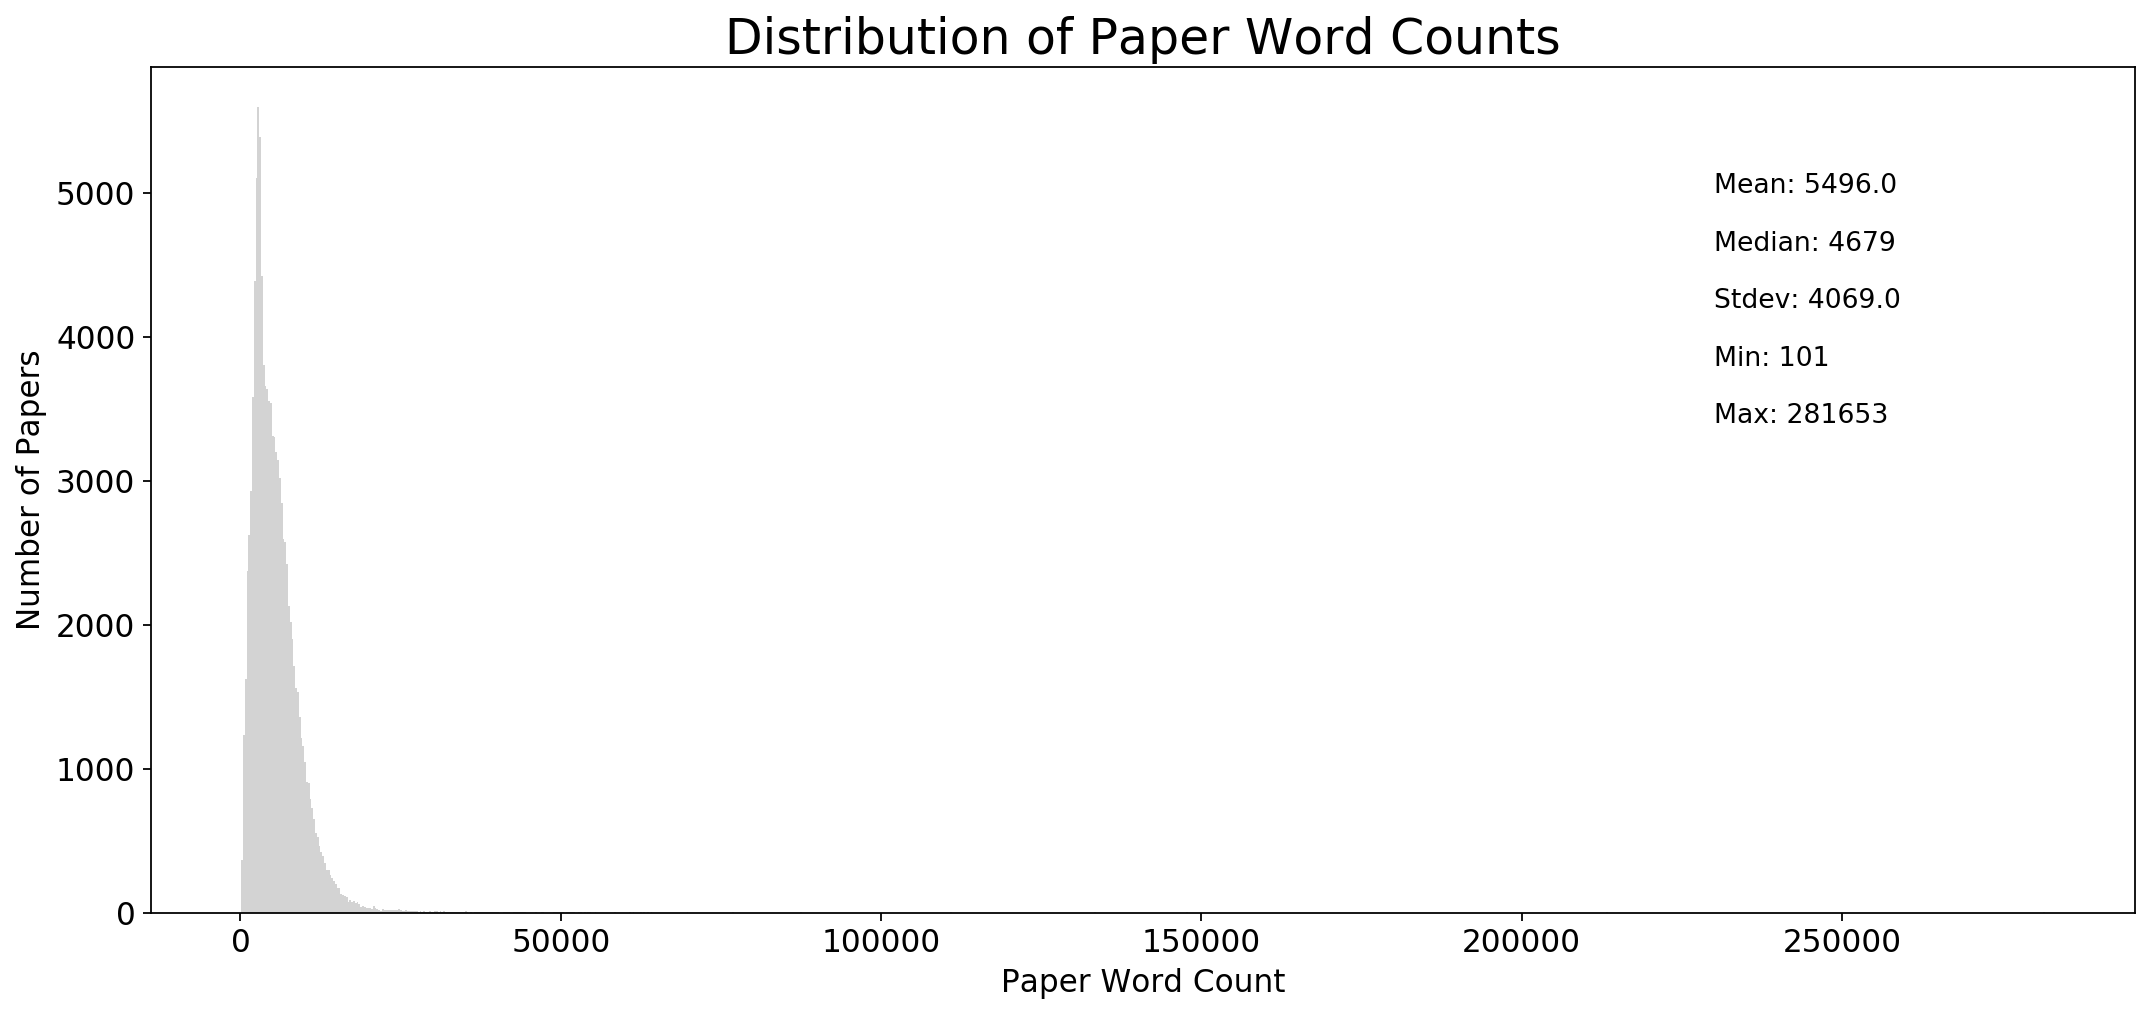

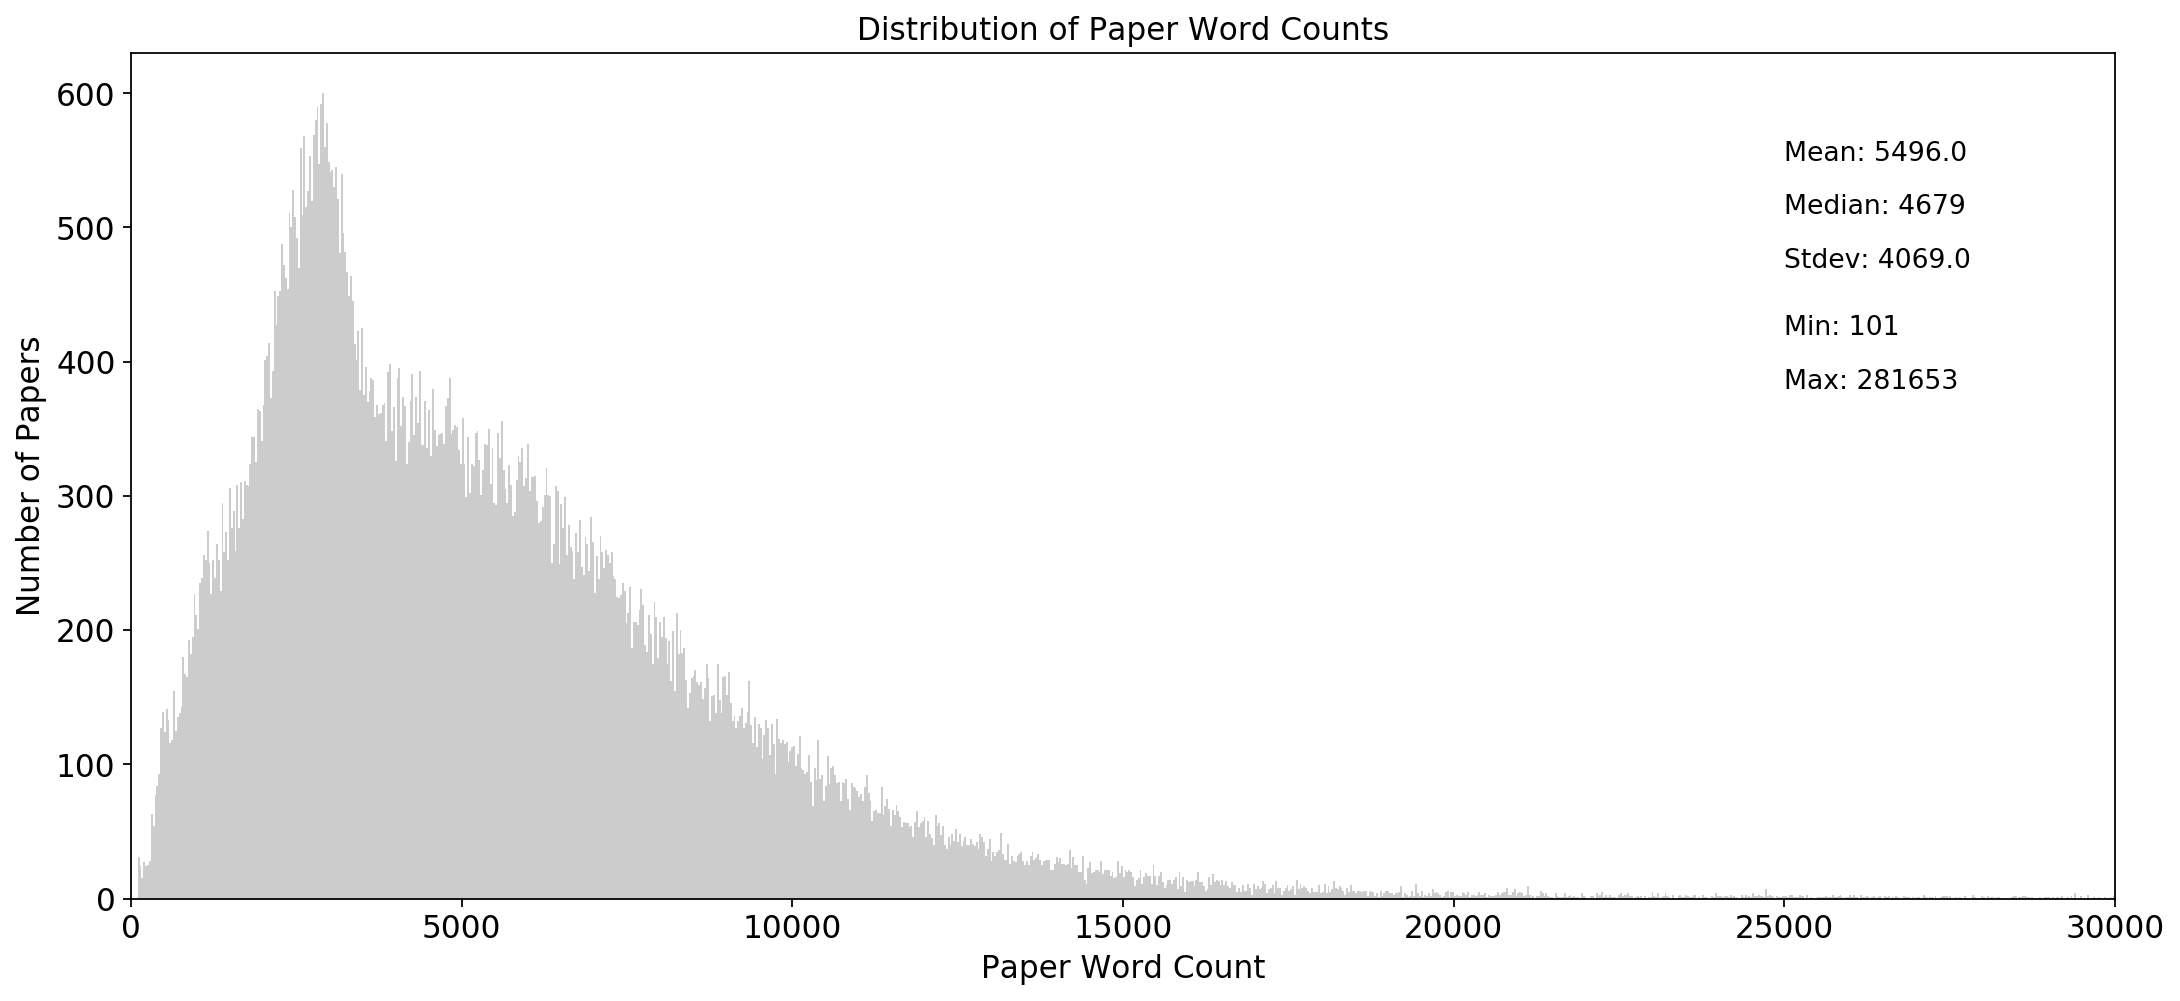

In [149]:
# VISUALIZE HOW BIG THE PAPERS ARE 
plt.figure(figsize=(16,7), dpi=160)
plt.hist(corpus_df['length'], bins=1000, color='lightgray')
plt.text(230000, 5000, "Mean: " + str(round(np.mean(corpus_df['length']))), size=12)
plt.text(230000,  4600, "Median: " + str(int(round(np.median(corpus_df['length'])))), size=12)
plt.text(230000,  4200, "Stdev: " + str(round(np.std(corpus_df['length']))), size=12)
plt.text(230000,  3800, "Min: " + str(round(np.min(corpus_df['length']))), size=12)
plt.text(230000,  3400, "Max: " + str(round(np.max(corpus_df['length']))), size=12)
plt.gca().set(ylabel='Number of Papers', xlabel='Paper Word Count')
plt.title('Distribution of Paper Word Counts', fontdict=dict(size=22))
plt.rc('xtick',labelsize=14)
plt.rc('axes',labelsize=14)
plt.rc('ytick',labelsize=14)
plt.show()

plt.figure(figsize=(16,7), dpi=160)
plt.hist(corpus_df['length'], bins=10000, color='#CCCCCC')
plt.text(25000, 550, "Mean: " + str(round(np.mean(corpus_df['length']))), size=12)
plt.text(25000,  510, "Median: " + str(int(round(np.median(corpus_df['length'])))), size=12)
plt.text(25000,  470, "Stdev: " + str(round(np.std(corpus_df['length']))), size=12)
plt.text(25000,  420, "Min: " + str(round(np.min(corpus_df['length']))), size=12)
plt.text(25000,  380, "Max: " + str(round(np.max(corpus_df['length']))), size=12)
plt.gca().set(xlim=(0, 30000), ylabel='Number of Papers', xlabel='Paper Word Count')
plt.title('Distribution of Paper Word Counts', fontdict=dict(size=14))
plt.show()

## Visualize

In [89]:
# Visualize lda model using mm corpus
topic_weights = []
for i, row_list in enumerate(lda[mm]):
    topic_weights.append([w for i, w in enumerate(row_list[0])])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
# arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
dominant_topics = arr.max(axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 110263 samples in 2.729s...
[t-SNE] Computed neighbors for 110263 samples in 3.438s...
[t-SNE] Computed conditional probabilities for sample 1000 / 110263
[t-SNE] Computed conditional probabilities for sample 2000 / 110263
[t-SNE] Computed conditional probabilities for sample 3000 / 110263
[t-SNE] Computed conditional probabilities for sample 4000 / 110263
[t-SNE] Computed conditional probabilities for sample 5000 / 110263
[t-SNE] Computed conditional probabilities for sample 6000 / 110263
[t-SNE] Computed conditional probabilities for sample 7000 / 110263
[t-SNE] Computed conditional probabilities for sample 8000 / 110263
[t-SNE] Computed conditional probabilities for sample 9000 / 110263
[t-SNE] Computed conditional probabilities for sample 10000 / 110263
[t-SNE] Computed conditional probabilities for sample 11000 / 110263
[t-SNE] Computed conditional probabilities for sample 12000 / 110263
[t-SNE] Computed conditional probabi

In [91]:
dominant_topics = arr.max(axis=1).astype(int)
dominant_topics

array([0, 1, 5, ..., 1, 0, 0])

In [137]:
mycolors = np.array(['#CCCCFF', '#FF6666', '#FFFF99', '#99CC33', '#66CCFF', '#6699FF', '#FF9966', '#CCCCCC', '#000000', '#FF6699'])
print('Colors: ' + str(mycolors))

Colors: ['#CCCCFF' '#FF6666' '#FFFF99' '#99CC33' '#66CCFF' '#6699FF' '#FF9966'
 '#CCCCCC' '#000000' '#FF6699']


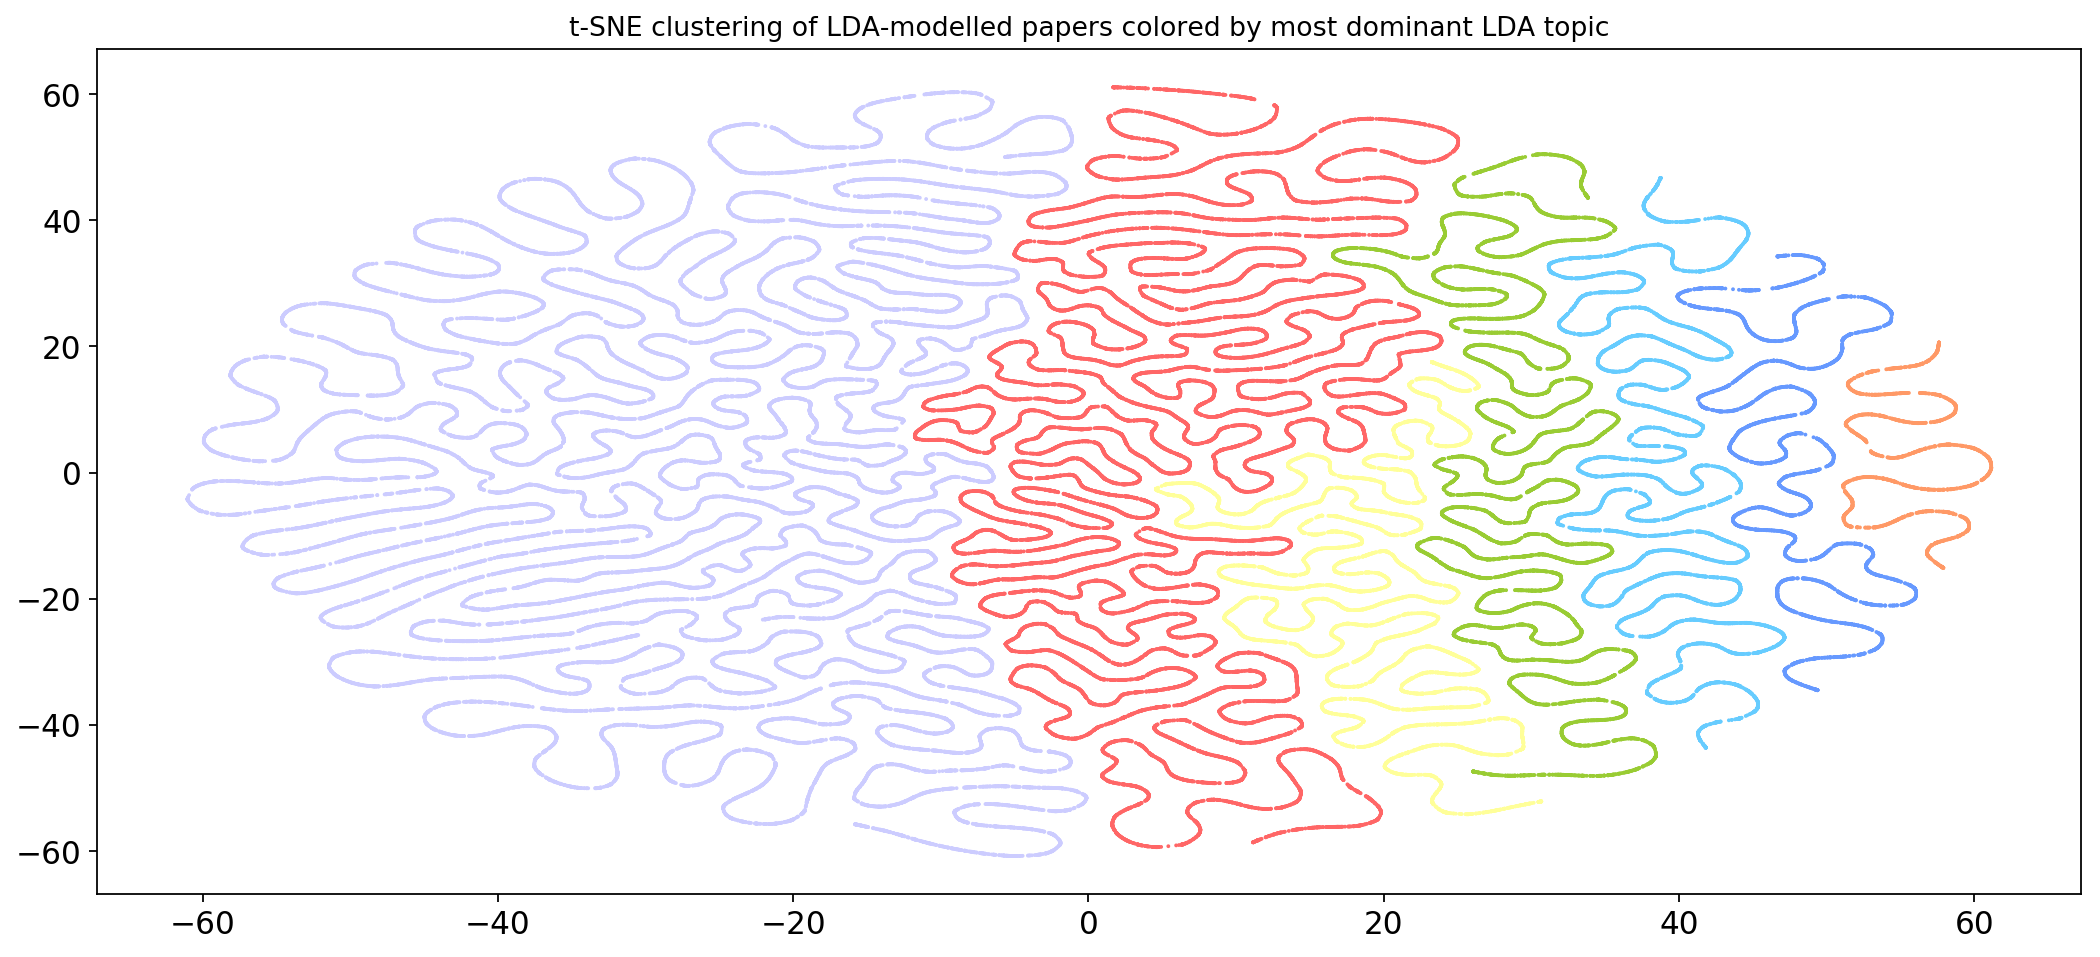

In [138]:
plt.figure(figsize=(16,7), dpi=160)
plt.title("t-SNE clustering of LDA-modelled papers colored by most dominant LDA topic".format(7))
plt.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], s=0.5, color=mycolors[dominant_topics])
plt.show()

[Text(0, 0.5, 'LDA topic'), Text(0.5, 0, 'Paper count')]

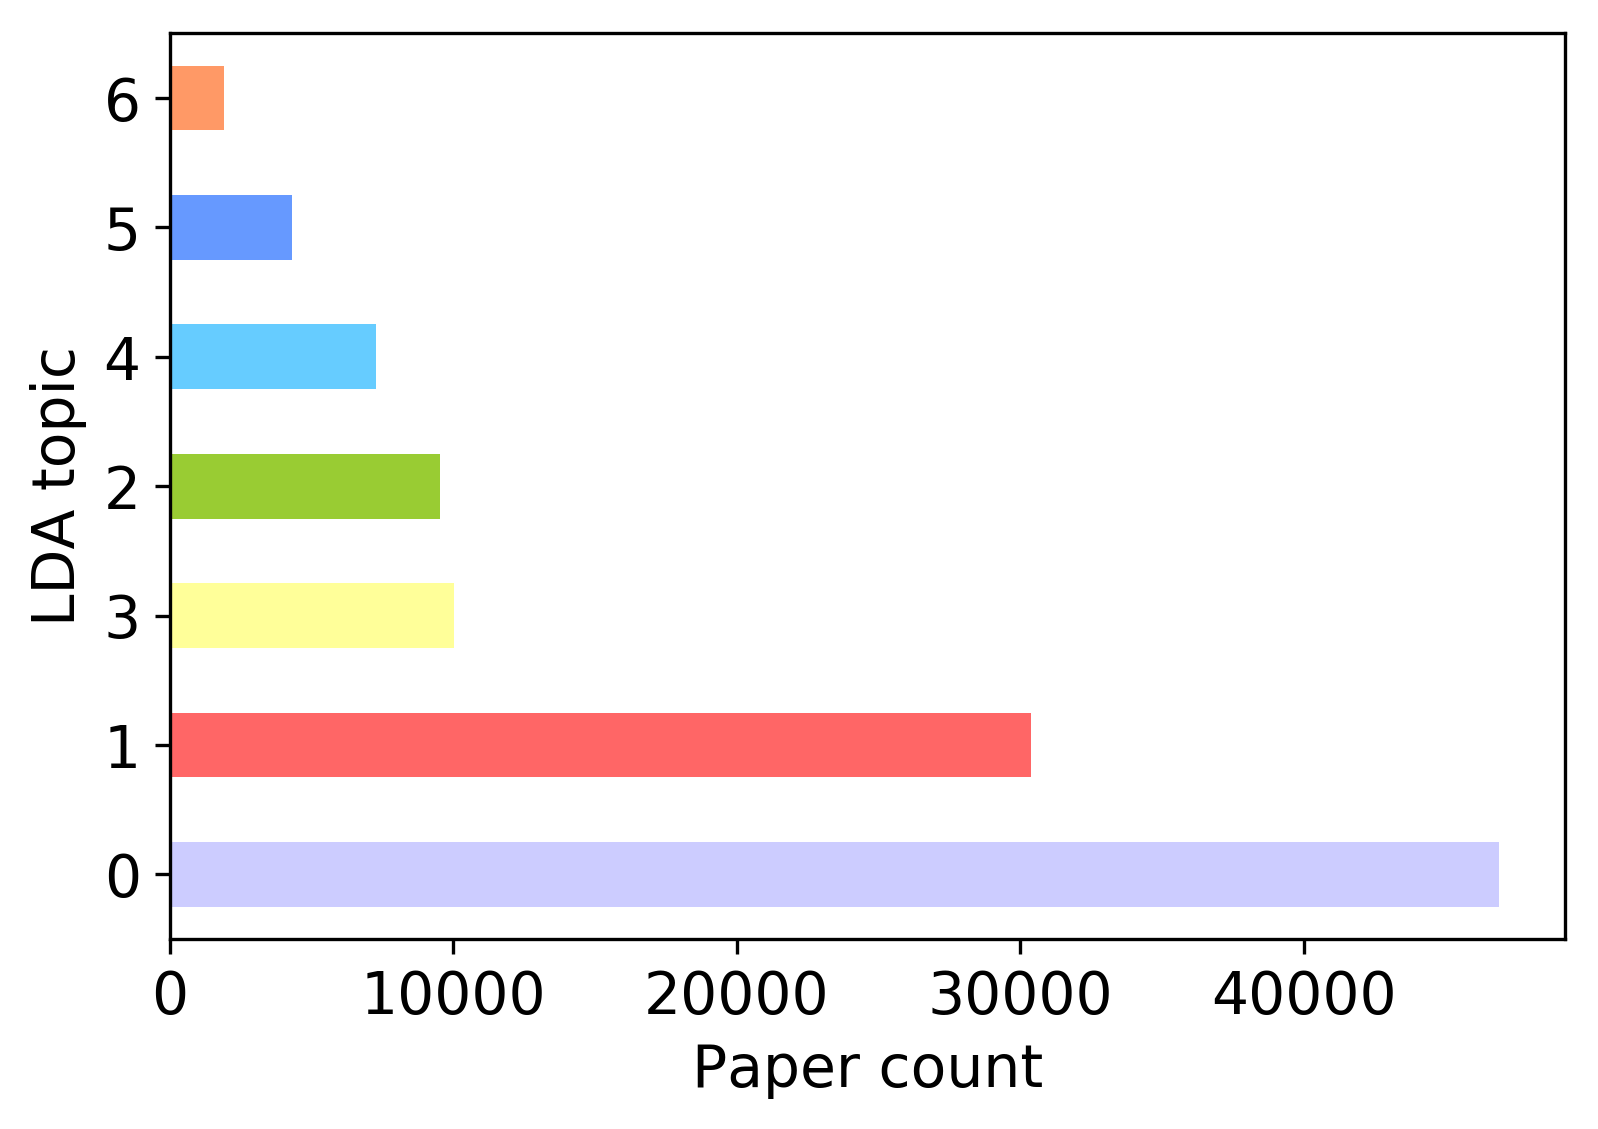

In [145]:
plt.figure(dpi=300)
pd.Series(dominant_topics).value_counts().plot(kind='barh', color=mycolors, fontsize=14, y='hi')
plt.gca().set(ylabel='LDA topic', xlabel='Paper count')

In [ ]:
plt.figure(dpi=300)
corpus_df['main'].value_counts().plot(kind='barh', color=mycolors, fontsize=14, y='hi')
plt.title("Paper frequency per author-assigned category".format(10), size=14)
plt.gca().set(ylabel='Number of Papers', xlabel='Category')

This person got similar worms: https://www.reddit.com/r/learnmachinelearning/comments/96pfno/what_clustering_algorithm_should_i_use_to_group/

In [ ]:
mycolors2 = np.array(['#CCCCFF', '#FF6666', '#FFFF99', '#99CC33', '#66CCFF', '#6699FF', '#FF9966', '#CCCCCC', '#000000', '#FF6699'])
print('Colors: ' + str(mycolors2))

In [99]:
# Try to obtain actual subjects, append to corpus_df
# (if mm matches up with corpus_df?)
corpus_df['main'].value_counts()

astro-ph       36810
astro-ph.CO    21475
astro-ph.SR    15605
astro-ph.HE    13361
astro-ph.GA    12471
astro-ph.EP     5611
astro-ph.IM     4930
Name: main, dtype: int64

In [96]:
# Replace category with corresponding integer so that it can be used as indices in mycolors
conditions = [
    (corpus_df['main'] == 'astro-ph'),
    (corpus_df['main'] == 'astro-ph.CO'),
    (corpus_df['main'] == 'astro-ph.SR'),
    (corpus_df['main'] == 'astro-ph.HE'),
    (corpus_df['main'] == 'astro-ph.GA'),
    (corpus_df['main'] == 'astro-ph.EP'),
    (corpus_df['main'] == 'astro-ph.IM')
]
choices = [0, 1, 2, 3, 4, 5, 6]
corpus_df['main_int'] = np.select(conditions, choices)
corpus_df

arxiv_id  length                           categories  \
0            1609.01265    2486        cond-mat.supr-con astro-ph.IM   
1             0906.3022   11970                          astro-ph.CO   
2             1112.0272     476                          astro-ph.GA   
3             1304.4591    3258                          astro-ph.SR   
4            1510.06165    1618                   hep-ph astro-ph.CO   
5             1408.0079    3367           astro-ph.SR hep-ph nucl-th   
6             0906.3168    6145                          astro-ph.SR   
7             1209.5938    6912                          astro-ph.CO   
8             1308.0475    2507                          astro-ph.HE   
9            1709.01527    3888                          astro-ph.EP   
10            1406.2086    3166                          astro-ph.GA   
11            1206.3042    7884                          astro-ph.EP   
12            1401.5518    2661                          astro-ph.SR   
13           1511.01680    2326                          astro-ph.IM   
14      astro-ph0411772   10262                             astro-ph   
15            1201.5104    6151         physics.atm-clus astro-ph.EP   
16            0910.2699    2721              astro-ph.CO astro-ph.IM   
17      astro-ph0207235    2696                             astro-ph   
18      astro-ph0106034    2084                             astro-ph   
19            1403.1103    2803             astro-ph.CO gr-qc hep-th   
20           1501.06445     780                          astro-ph.SR   
21            0902.1212    3831                          astro-ph.SR   
22            1307.6035    5287                          astro-ph.GA   
23      astro-ph0404318    9162                             astro-ph   
24      astro-ph0202180    1700                             astro-ph   
25            1008.1845   12521                          astro-ph.CO   
26            1010.5527    8456                          astro-ph.EP   
27           1608.08842   12726              astro-ph.SR astro-ph.GA   
28            1403.6120    2050                   hep-th astro-ph.CO   
29            0809.4871    3227                             astro-ph   
...                 ...     ...                                  ...   
110233        1111.3653    6058                          astro-ph.SR   
110234        1304.1180    4533                          astro-ph.IM   
110235  astro-ph0410265    1533                             astro-ph   
110236        1302.4232    4042                          astro-ph.EP   
110237        1305.3270    1782                          astro-ph.SR   
110238       1507.07987    5056                   hep-ph astro-ph.HE   
110239  astro-ph0304403   12212                             astro-ph   
110240        1210.1880    6038             astro-ph.CO gr-qc hep-th   
110241        1111.0557    1142                          astro-ph.CO   
110242       1804.05056    8529                          astro-ph.HE   
110243        1312.1862    5185                    gr-qc astro-ph.CO   
110244  astro-ph0201141    7216                             astro-ph   
110245  astro-ph0201191    1354                             astro-ph   
110246       1610.01427    2573              astro-ph.HE astro-ph.IM   
110247       1512.04359    2223              astro-ph.CO astro-ph.GA   
110248        1105.0651     106             astro-ph.CO gr-qc hep-th   
110249        1009.4189    4177                   astro-ph.CO hep-ph   
110250       1609.04403    6878                          astro-ph.HE   
110251  astro-ph0207386     849                             astro-ph   
110252       1507.00733     848                          astro-ph.GA   
110253        1204.4530    8250             astro-ph.CO gr-qc hep-ph   
110254        1112.2253    3266                          astro-ph.HE   
110255       1707.09017    4682                          astro-ph.SR   
110256        1311.0880    3238                   hep-p

In [97]:
len(mm) == len(corpus_df)

True

In [ ]:
# Find model accuracy on 


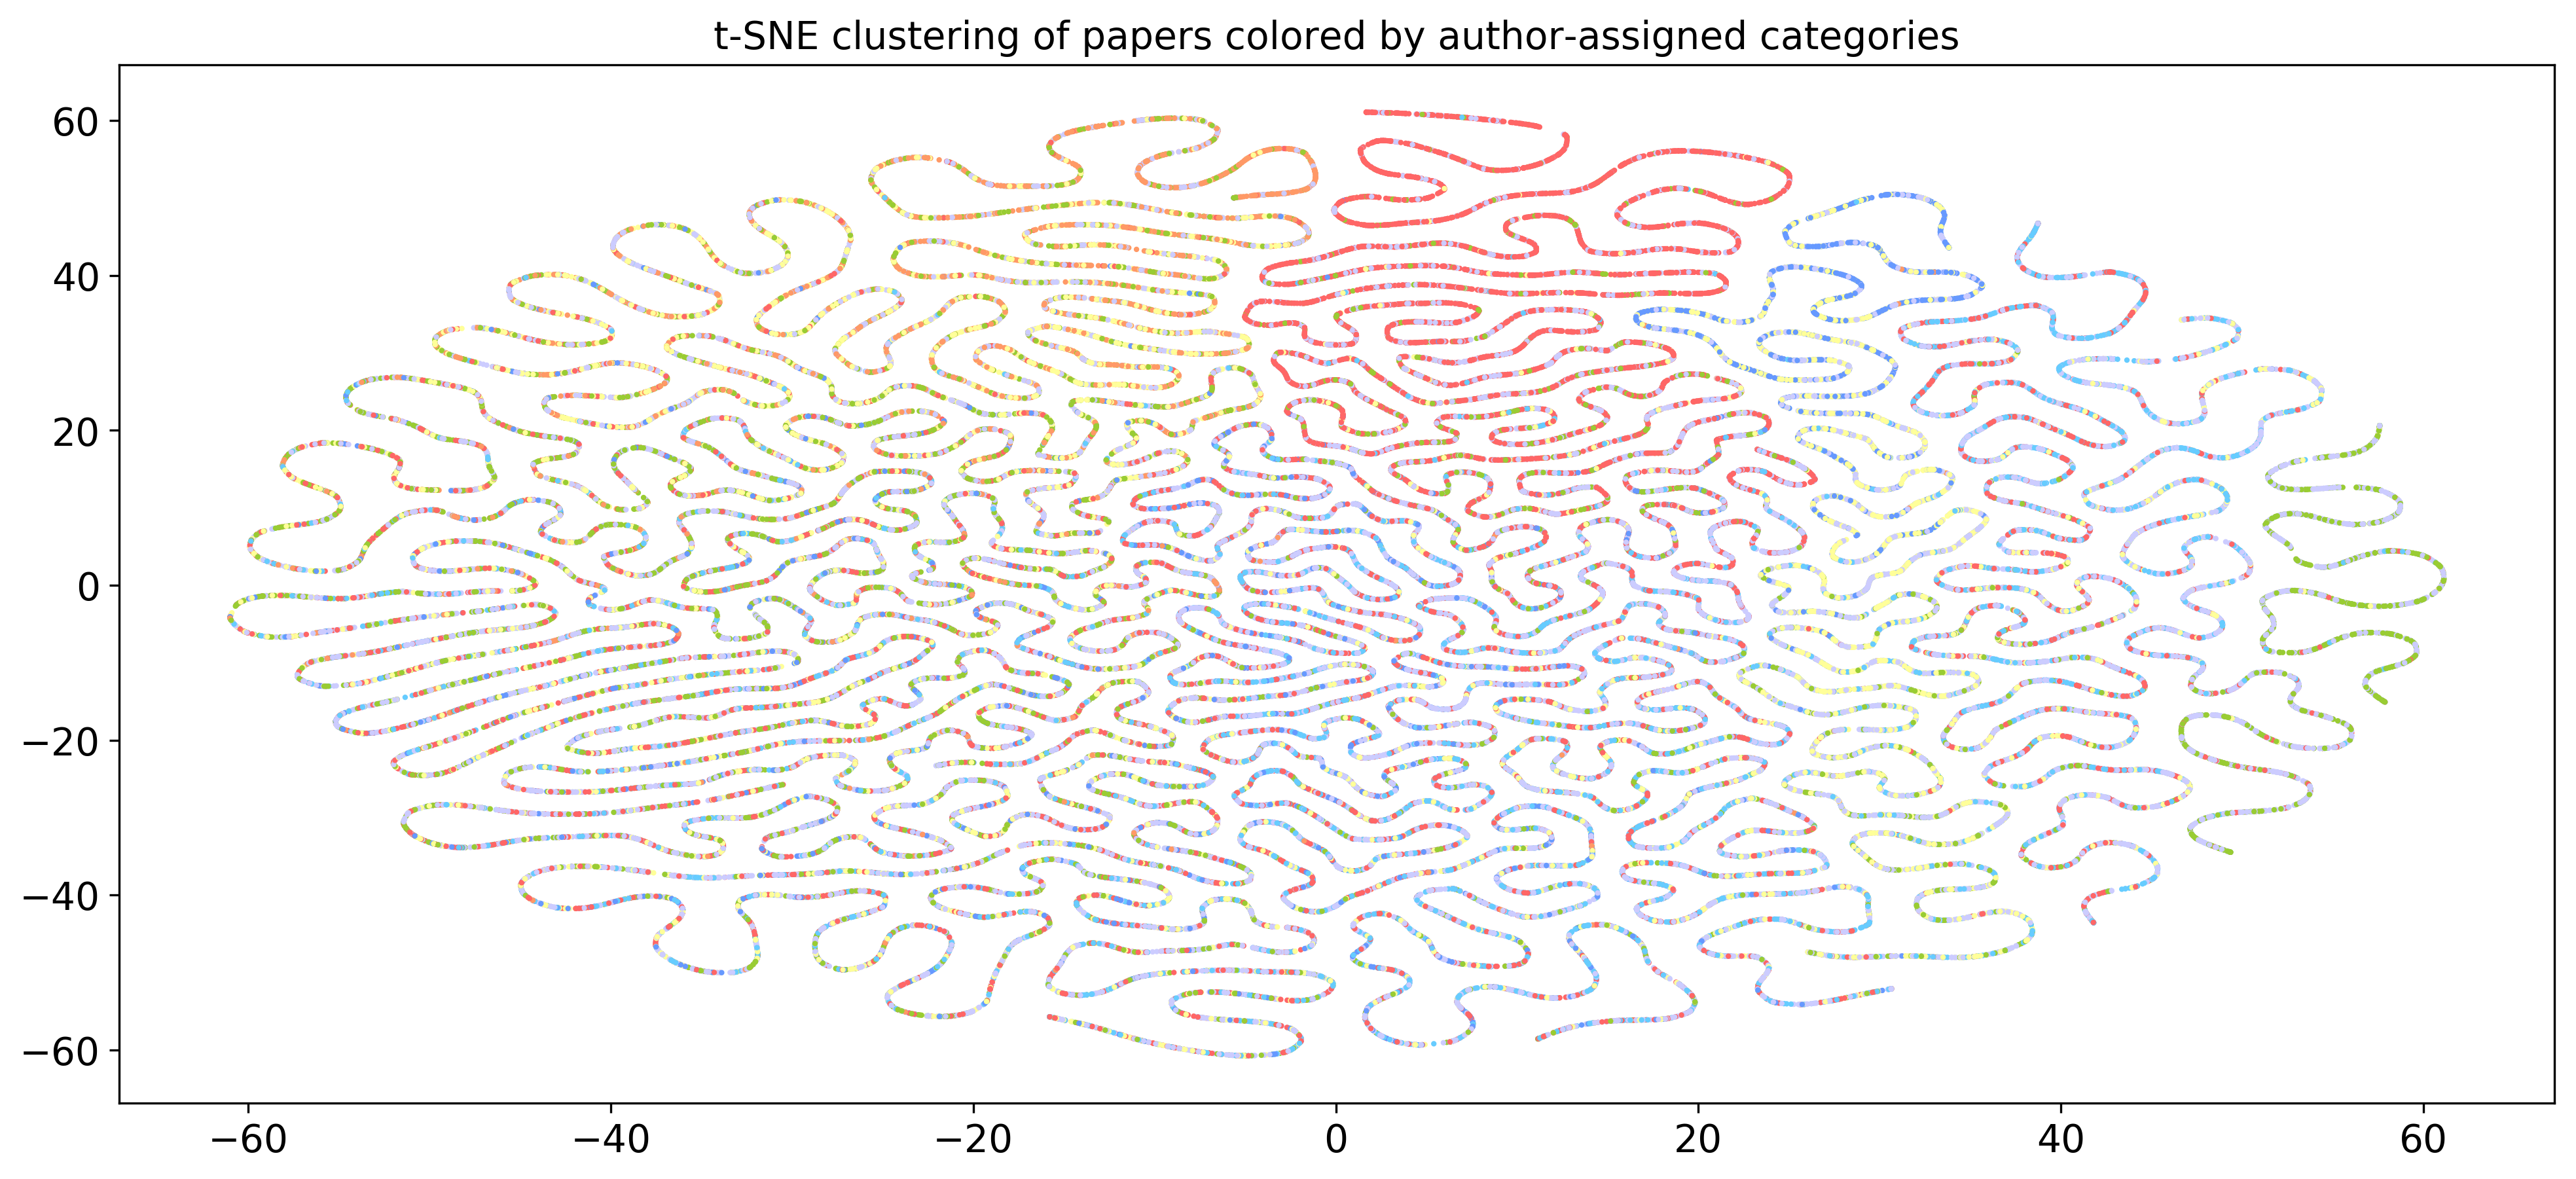

In [146]:
plt.figure(figsize=(16,7), dpi=300)
plt.title("t-SNE clustering of papers colored by author-assigned categories".format(10), size=14)
plt.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], s=1, color=mycolors[corpus_df['main_int']])
plt.show()

[Text(0, 0.5, 'Author-assigned category'), Text(0.5, 0, 'Paper count')]

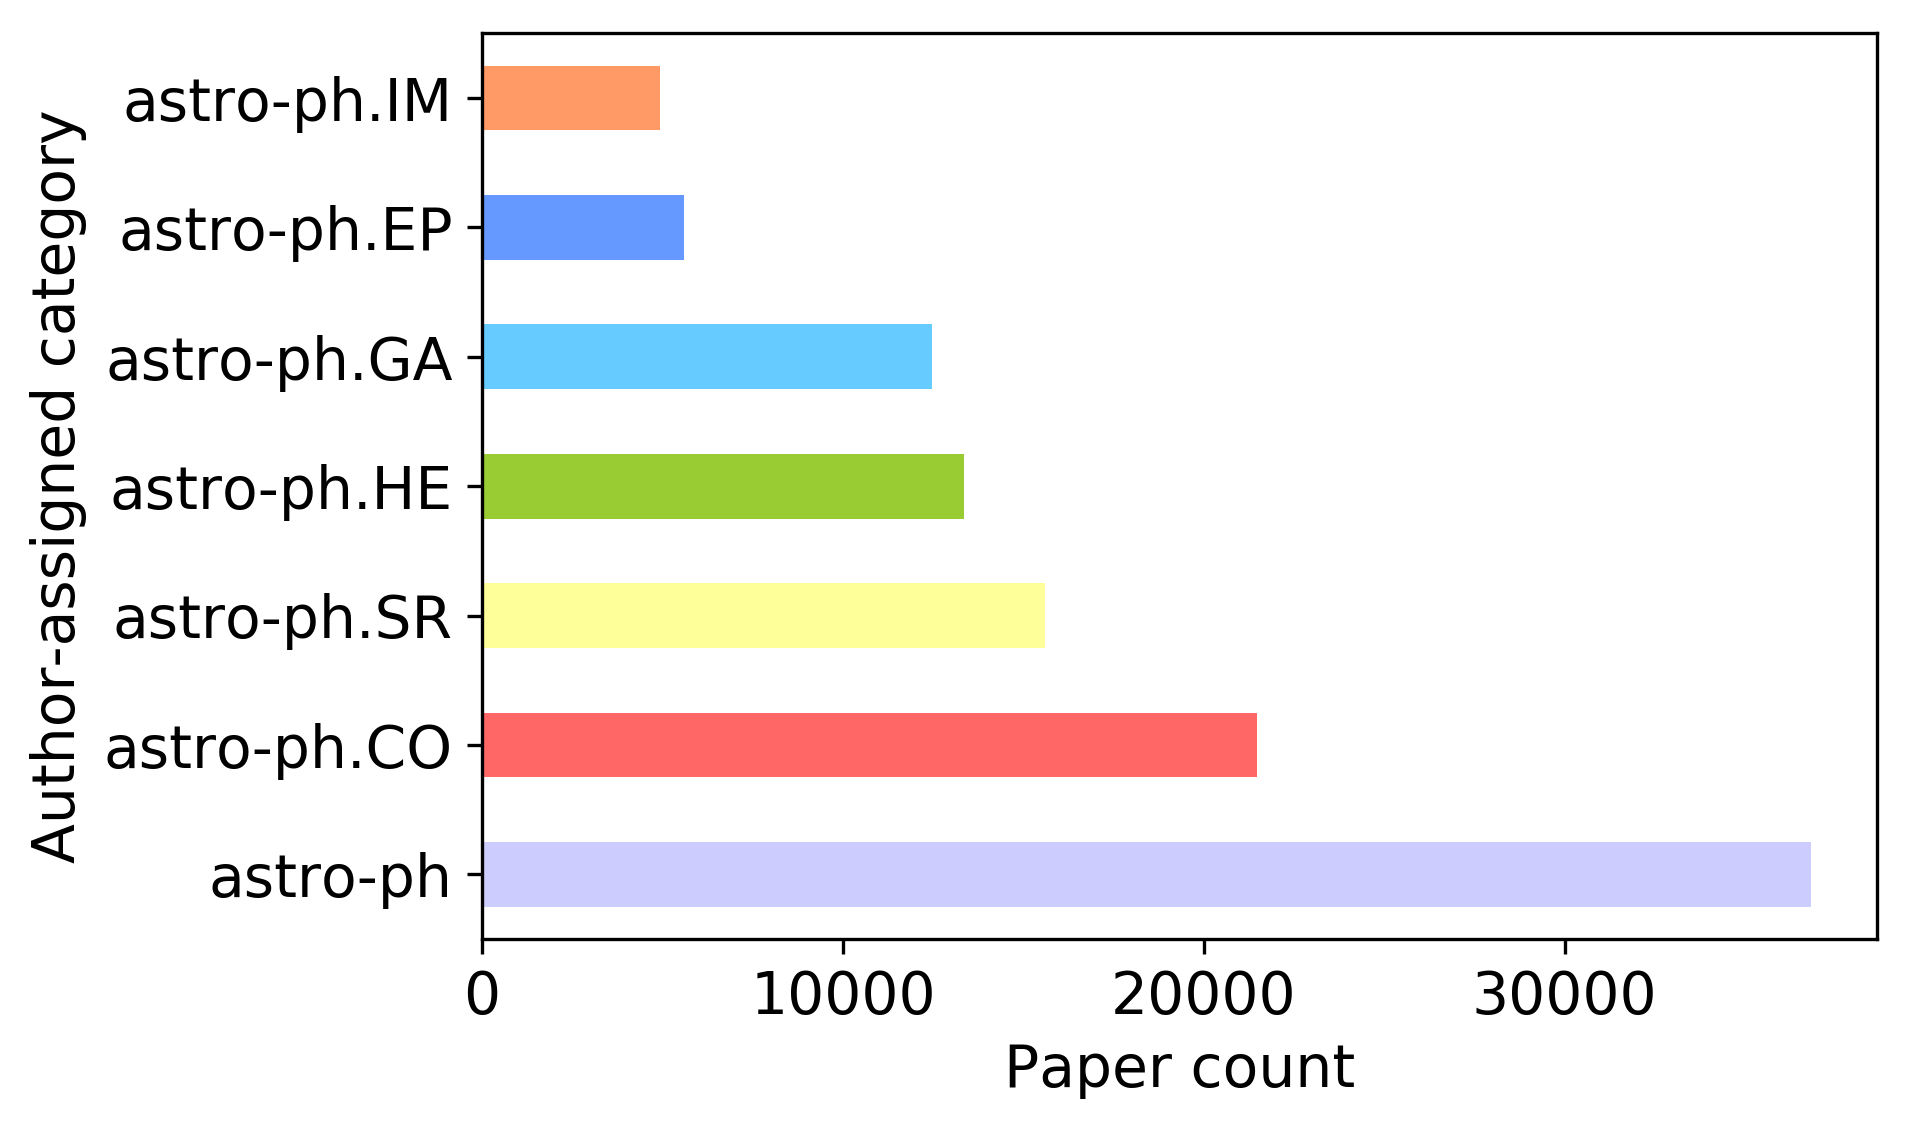

In [148]:
# Visualize frequencies of these categories
plt.figure(dpi=300)
corpus_df['main'].value_counts().plot(kind='barh', color=mycolors, fontsize=14, y='hi')
plt.gca().set(ylabel='Author-assigned category', xlabel='Paper count')

In [275]:
# See words in the topics
str_topics = [topic_w for topic_number, topic_w in lda.show_topics(num_words=100)]
str_topics_split = list(map(lambda x: x.split("+"), str_topics))
weights = [list(map(lambda x: x.split("*")[0].strip()[1:], elem)) for elem in str_topics_split]
topics = [list(map(lambda x: x.split("*")[1].strip()[1:-1], elem)) for elem in str_topics_split]

In [238]:
import nltk
nltk.download('stopwords')
stoplist = set(stopwords.words('english'))
stoplist.add('<latex>')
stoplist.add('<num>')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Total words: 100
0: ['energy', 'data', 'magnetic', 'field', 'time', 'also', 'flux', 'model', 'figure', 'used', 'solar', 'using', 'high', 'different', 'number', 'results', 'signal', 'large', 'source', 'noise']
[0.086 0.039 0.024 0.023 0.021 0.02  0.02  0.018 0.016 0.011 0.008 0.008
 0.008 0.008 0.007 0.007 0.007 0.006 0.006 0.006]


<Figure size 432x288 with 0 Axes>

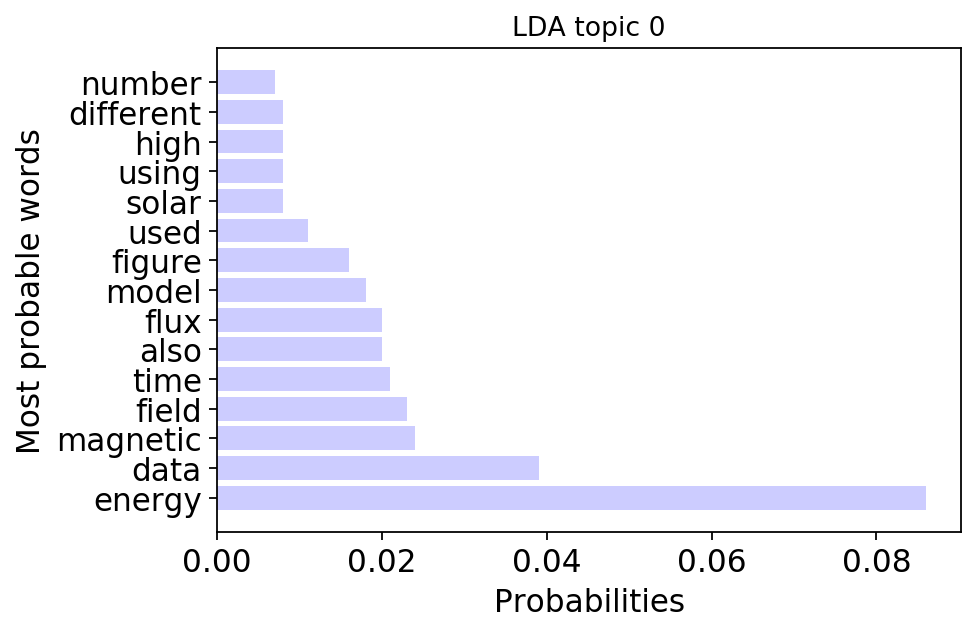

Total words: 100
1: ['field', 'energy', 'model', 'density', 'mass', 'time', 'case', 'equation', 'also', 'matter', 'order', 'given', 'scale', 'models', 'function', 'large', 'value', 'however', 'dark', 'equations']
[0.094 0.067 0.036 0.025 0.022 0.021 0.021 0.017 0.012 0.012 0.011 0.008
 0.008 0.008 0.008 0.008 0.007 0.007 0.005 0.005]


<Figure size 432x288 with 0 Axes>

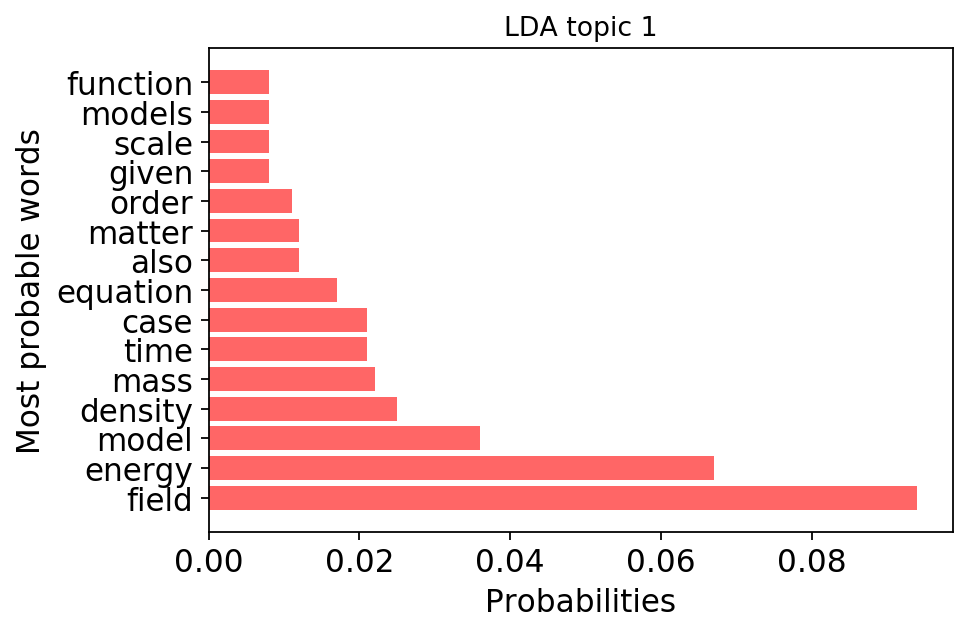

Total words: 100
2: ['mass', 'model', 'data', 'density', 'observed', 'also', 'galaxies', 'emission', 'field', 'line', 'high', 'distribution', 'galaxy', 'using', 'energy', 'stars', 'large', 'cluster', 'models', 'star']
[0.099 0.042 0.034 0.03  0.026 0.024 0.02  0.019 0.015 0.011 0.009 0.009
 0.008 0.008 0.007 0.006 0.006 0.006 0.006 0.006]


<Figure size 432x288 with 0 Axes>

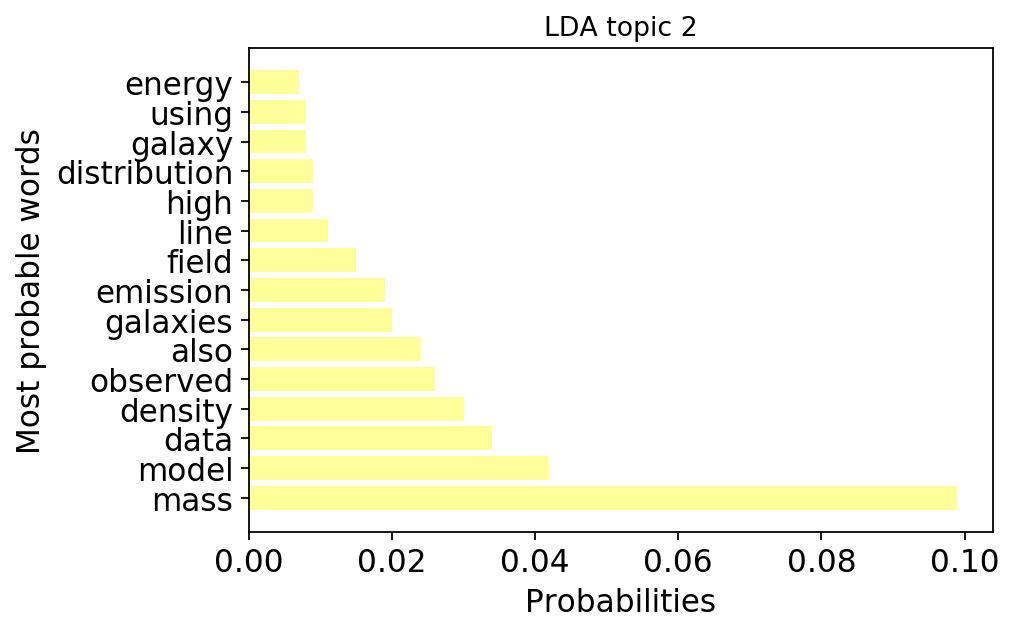

Total words: 100
3: ['data', 'stars', 'planet', 'star', 'also', 'model', 'time', 'period', 'mass', 'planets', 'observations', 'system', 'orbital', 'disk', 'observed', 'using', 'light', 'stellar', 'results', 'values']
[0.093 0.037 0.036 0.025 0.021 0.02  0.02  0.018 0.014 0.012 0.009 0.009
 0.009 0.008 0.007 0.007 0.007 0.007 0.006 0.005]


<Figure size 432x288 with 0 Axes>

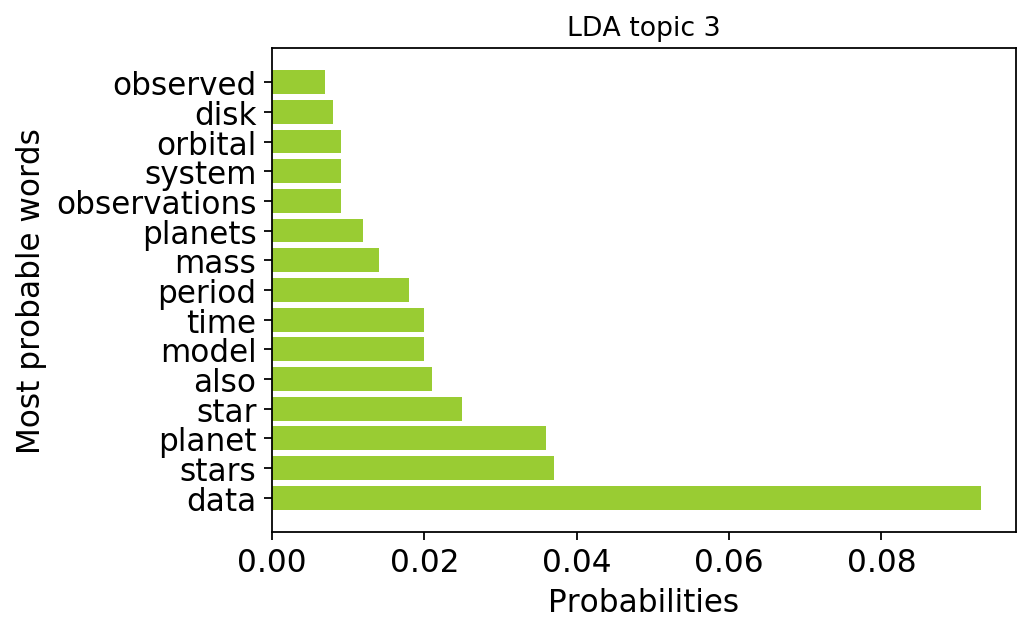

Total words: 100
4: ['mass', 'galaxies', 'stars', 'galaxy', 'stellar', 'star', 'cluster', 'also', 'formation', 'model', 'clusters', 'sample', 'halo', 'data', 'using', 'distribution', 'models', 'figure', 'velocity', 'density']
[0.081 0.039 0.026 0.023 0.021 0.02  0.02  0.019 0.015 0.011 0.01  0.01
 0.009 0.008 0.008 0.007 0.007 0.007 0.006 0.006]


<Figure size 432x288 with 0 Axes>

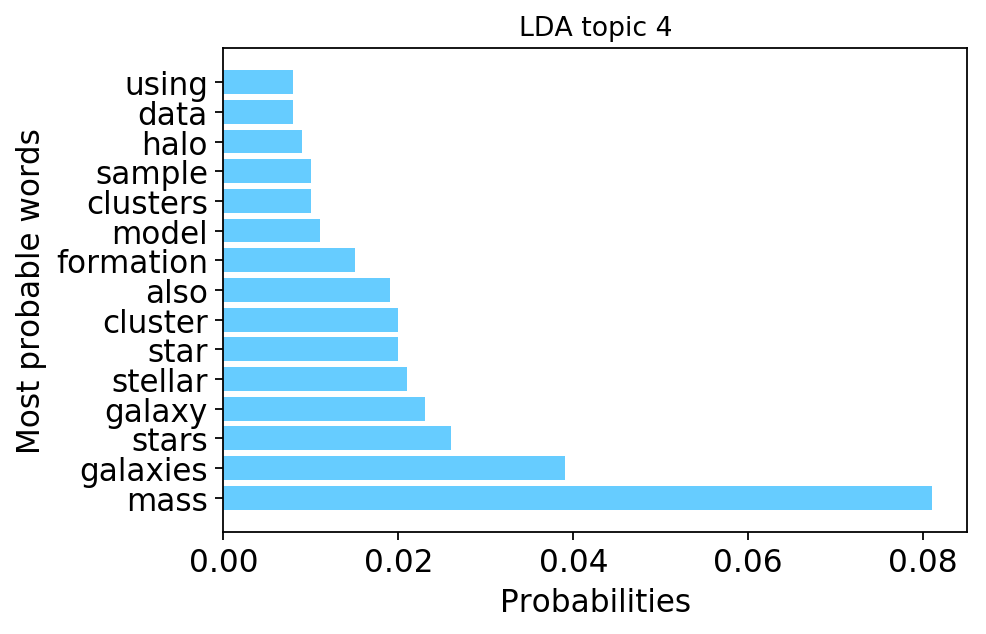

Total words: 100
5: ['emission', 'line', 'galaxies', 'star', 'stars', 'dust', 'lines', 'mass', 'data', 'also', 'high', 'observed', 'sample', 'density', 'observations', 'using', 'sources', 'spectra', 'velocity', 'flux']
[0.075 0.053 0.04  0.035 0.024 0.021 0.018 0.015 0.014 0.011 0.009 0.009
 0.008 0.008 0.007 0.007 0.007 0.007 0.006 0.006]


<Figure size 432x288 with 0 Axes>

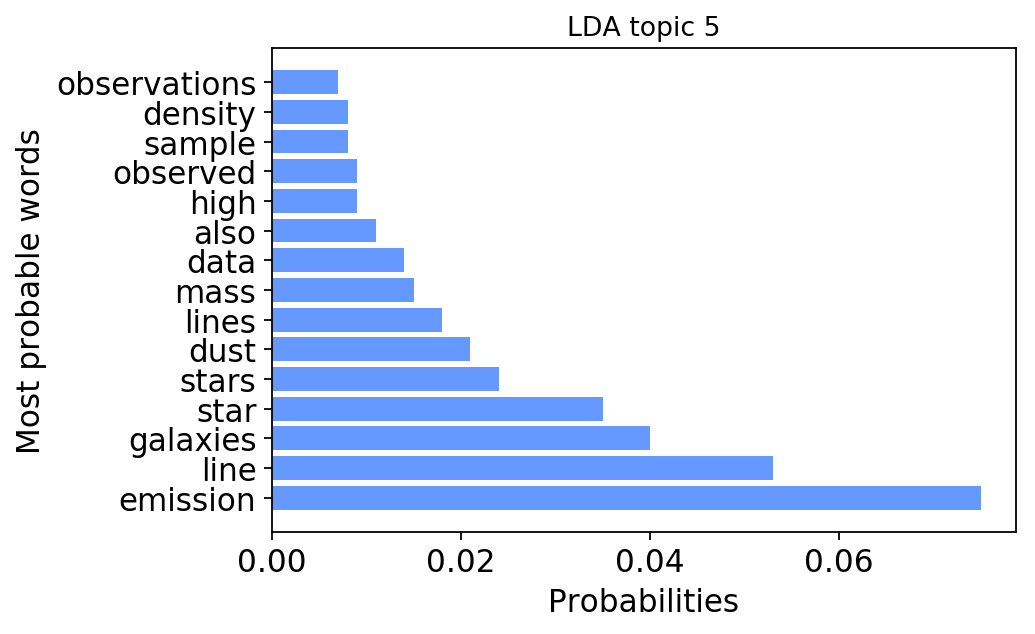

Total words: 100
6: ['emission', 'model', 'data', 'source', 'energy', 'also', 'observed', 'sources', 'observations', 'flux', 'spectrum', 'time', 'mass', 'line', 'luminosity', 'radio', 'spectral', 'high', 'optical', 'using']
[0.077 0.045 0.038 0.035 0.025 0.02  0.02  0.015 0.014 0.011 0.01  0.009
 0.009 0.007 0.007 0.007 0.007 0.007 0.006 0.006]


<Figure size 432x288 with 0 Axes>

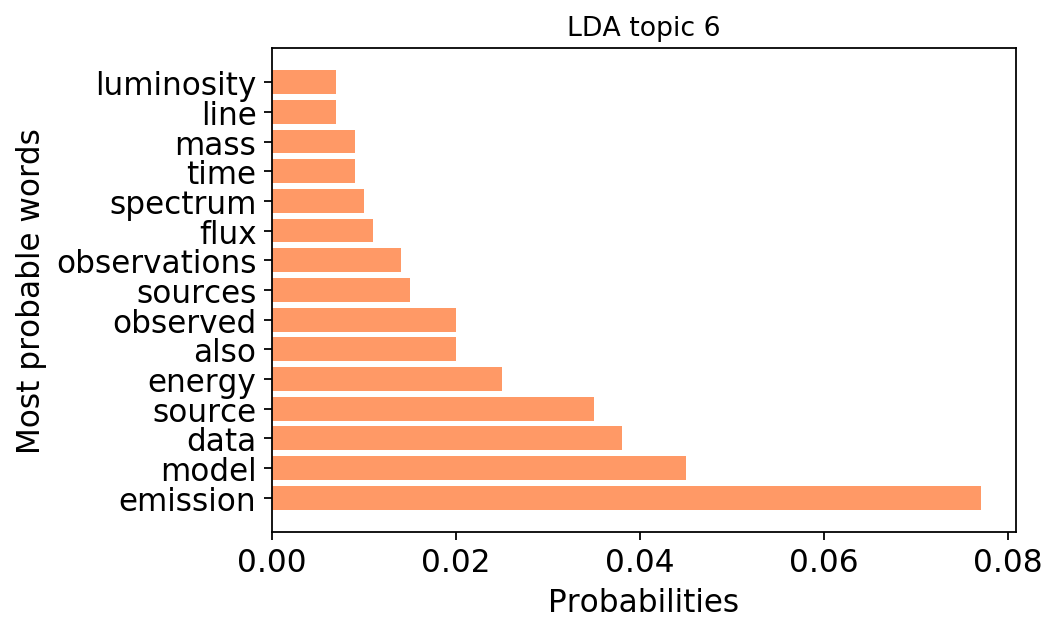

In [291]:
for index, topic in enumerate(topics):
    print('Total words: ' + str(len(topic)))
    new_topic = [word for word in topic if word not in stoplist and len(word) > 3]
    print(str(index) + ': ' + str(new_topic[0:20]))
    np.set_printoptions(precision=4)
    print(np.array(weights[index][0:20]).astype(float))
    plt.figure()
    color = '#CCCCFF'
    if index == 1:
        color = '#FF6666'
    elif index == 2:
        color = '#FFFF99'
    elif index == 3:
        color = '#99CC33'
    elif index == 4:
        color = '#66CCFF'
    elif index == 5:
        color = '#6699FF'
    elif index == 6:
        color = '#FF9966'
    plt.figure(dpi=160)
    plt.barh(new_topic[0:15], np.array(weights[index][0:15]).astype(float), color=color)
    plt.gca().set(ylabel='Most probable words', xlabel='Probabilities')
    plt.title('LDA topic ' + str(index))
    plt.show()

None


In [221]:
from collections import Counter
topics = lda.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

110263

## Add subjects to corpus dataframe

In [142]:
print(len(mm[0]))
print(corpus_df['length'].iloc[0])

638
2486


# Removing most frequent words

In [ ]:
tfidf = gs.models.TfidfModel(corpus, id2word=dictionary)

In [ ]:
for bow in corpus:
    for value in tfidf[bow]:
        print(value)

In [ ]:
low_value = 0.05
low_value_words = []
for bow in corpus:
    low_value_words += [id for id, value in tfidf[bow] if value < low_value]

In [ ]:
# Filter low-value words out of dictionary
dictionary.filter_tokens(bad_ids=low_value_words)

In [ ]:
len(dictionary)

In [ ]:
corpus = MyCorpus()
print('Running LDA on ' + str(mp.cpu_count() - 1) + ' cores')

start = time.time()
lda_stopwords = gs.models.LdaMulticore(corpus=corpus, 
                                 workers=mp.cpu_count() - 1,
                                 id2word=dictionary,
                                 num_topics=10,
                                 chunksize=10000,
                                 passes=10)
lda_stopwords.save('lda_stopwords.model')
print(str(time.time() - start) + 'ms')

Visualize to see if more than 2 colors show up:

In [ ]:
gs.corpora.MmCorpus.serialize('SerializedCorpus_stopwords.mm', corpus)
pyLDAvis.enable_notebook()
SerializedCorpus_stopwords = gs.corpora.MmCorpus('SerializedCorpus_stopwords.mm')

lda_stopwords[SerializedCorpus_stopwords][1][0]

In [ ]:
topic_weights2 = []
for i, row_list in enumerate(lda_stopwords[SerializedCorpus_stopwords]):
    topic_weights2.append([w for i, w in enumerate(row_list[0])])

# Array of topic weights    
arr2 = pd.DataFrame(topic_weights2).fillna(0).values

# Keep the well separated points (optional)
# arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num2 = arr2.argmax(arr2, axis=1)

# tSNE Dimension Reduction
tsne_model2 = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda2 = tsne_model2.fit_transform(arr2)

In [ ]:
# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 10
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
mycolors

In [ ]:
plt.figure(figsize=(16,7), dpi=160)
plt.title("t-SNE Clustering of {} LDA Topics with stopwords removed".format(n_topics))
plt.scatter(x=tsne_lda2[:,0], y=tsne_lda2[:,1], color=mycolors[topic_num3])
plt.show()

In [ ]:
len(topic_weights) == len(SerializedCorpus_stopwords)
len(arr)

In [ ]:
for i in topic_num3:
    print(i)

In [ ]:
arr3 = pd.DataFrame(topic_weights2).fillna(0).values
topic_num3 = arr3.max(axis=1)
topic_num3 = topic_num3.astype(int)
len(topic_num3)

In [ ]:
tsne_lda2

In [ ]:
title = '20 newsgroups LDA viz'
num_example = len(topic_num2)

plot_lda = bp.figure(plot_width=1400, plot_height=1100,
                     title=title,
                     tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
                     x_axis_type=None, y_axis_type=None, min_border=1)

plot_lda.scatter(x=tsne_lda2[:, 0], y=tsne_lda2[:, 1],
                 color=mycolors[topic_num2][:num_example])

# randomly choose a news (within a topic) coordinate as the crucial words coordinate
topic_coord = np.empty((num_topics2.shape[1], 2)) * np.nan
for topic_num in _lda_keys:
  if not np.isnan(topic_coord).any():
    break
  topic_coord[topic_num] = tsne_lda[_lda_keys.index(topic_num)]

# plot crucial words
for i in xrange(X_topics.shape[1]):
  plot_lda.text(topic_coord[i, 0], topic_coord[i, 1], [topic_summaries[i]])

# hover tools
hover = plot_lda.select(dict(type=HoverTool))
hover.tooltips = {"content": "@content - topic: @topic_key"}

# save the plot
save(plot_lda, '{}.html'.format(title))


# Visualize

In [ ]:
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

In [ ]:
lda[SerializedCorpus][1][0]

In [ ]:
topic_weights = []
for i, row_list in enumerate(lda[SerializedCorpus]):
    topic_weights.append([w for i, w in enumerate(row_list[0])])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

In [ ]:
len(topic_num)

In [ ]:
# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 10
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])

In [ ]:
mycolors

In [ ]:
plt.title("t-SNE Clustering of {} LDA Topics".format(n_topics))
plt.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
plt.show()

In [ ]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda, SerializedCorpus, dictionary=lda.id2word)
vis

## Recommending papers with LDA

In [ ]:
#gs.corpora.MmCorpus.serialize('SerializedCorpus.mm', corpus)
#SerializedCorpus = gensim.corpora.MmCorpus('SerializedCorpus.mm')
lda_display = pyLDAvis.gensim.prepare(lda, SerializedCorpus, dictionary, sort_topics=False)
#pyLDAvis.save_html(vis_data,outpth+'LDA_Visualization.html')
pyLDAvis.display(lda_display)

In [10]:
# Get the first document
lda[mm][0] 

[(0, 0.69405293), (1, 0.01893171), (2, 0.013491711), (7, 0.27328232)]

In [46]:
# Get its nearest neighbors
index = gs.similarities.Similarity(corpus=lda[mm], num_features=len(dictionary), output_prefix='similarities') # using Similarity instead of MatrixSimilarity due to memory
index.save('lda_110k_similarities.index')

2019-04-10 19:11:05,243 : INFO : starting similarity index under similarities
2019-04-10 19:11:28,873 : INFO : PROGRESS: fresh_shard size=10000
2019-04-10 19:11:52,967 : INFO : PROGRESS: fresh_shard size=20000
2019-04-10 19:12:16,940 : INFO : PROGRESS: fresh_shard size=30000
2019-04-10 19:12:23,570 : INFO : creating sparse index
2019-04-10 19:12:23,571 : INFO : creating sparse matrix from corpus
2019-04-10 19:12:23,572 : INFO : PROGRESS: at document #0/32768
2019-04-10 19:12:23,754 : INFO : PROGRESS: at document #10000/32768
2019-04-10 19:12:23,936 : INFO : PROGRESS: at document #20000/32768
2019-04-10 19:12:24,119 : INFO : PROGRESS: at document #30000/32768
2019-04-10 19:12:24,175 : INFO : created <32768x516607 sparse matrix of type '<class 'numpy.float32'>'
	with 111980 stored elements in Compressed Sparse Row format>
2019-04-10 19:12:24,176 : INFO : creating sparse shard #0
2019-04-10 19:12:24,177 : INFO : saving index shard to similarities.0
2019-04-10 19:12:24,177 : INFO : saving 

In [11]:
# Load index
index = gs.similarities.Similarity.load('lda_110k_similarities.index')

2019-04-10 19:34:21,853 : INFO : loading Similarity object from lda_110k_similarities.index
2019-04-10 19:34:21,854 : INFO : loaded lda_110k_similarities.index


In [27]:
sims = index[lda[mm][1]]
sims = sorted(enumerate(sims), key=lambda item: -item[1])
print(sims[:5])
print(sims[:6])

[(1, 0.99999917), (2255, 0.99999857), (93623, 0.9999938), (1219, 0.99999243), (2745, 0.9999912)]
[(1, 0.99999917), (2255, 0.99999857), (93623, 0.9999938), (1219, 0.99999243), (2745, 0.9999912), (2575, 0.9999799)]


In [28]:
corpus_df.iloc[2575]

arxiv_id       1501.03083
length               3066
categories    astro-ph.GA
main          astro-ph.GA
Name: 2575, dtype: object

In [19]:
doc = corpus_df.iloc[0].arxiv_id
print(doc)

1609.01265


In [ ]:
# Prepare for similarity queries
index = gensim.similarities.Similarity(corpus=lda[corpus], num_features=len(dictionary), output_prefix='similarities') # using Similarity instead of MatrixSimilarity due to memory
# index.save('similarities.index')

In [ ]:
# Obtain similarity of our query against our indexed papers
sims = index[vec_lda]  # perform a similarity query against the corpus
print(list(enumerate(sims)))  # print (document_number, document_similarity) 2-tuples

In [ ]:
sims = sorted(enumerate(sims), key=lambda item: -item[1])
print(sims)  # print sorted (document number, similarity score) 2-tuples

In [ ]:
corpus_df.iloc[[2027]]

In [ ]:
corpus_df.iloc[[0]]

Query was: https://arxiv.org/pdf/0704.0009.pdf

Result was: https://arxiv.org/pdf/0706.1809.pdf

They are similar!

## Extra

In [ ]:
# Find dominant topic of each document and its percentage contribution in the document
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda, corpus=MyCorpus(), texts=dictionary)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

In [ ]:
for idx, topic in lda.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic))
    print("\n")

In [ ]:
x=lda.show_topics(num_topics=10, num_words=100,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Topics and Words
for topic,words in topics_words:
    print(str(topic)+ "::"+ str(words))
print()

#Below Code Prints Only Words 
for topic,words in topics_words:
    print(" ".join(words))

In [ ]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

In [ ]:
from collections import Counter
topics = lda.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()